# Overview

Intracranial hemorrhage, bleeding that occurs inside the cranium, is a serious health problem requiring rapid and often intensive medical treatment. For example, intracranial hemorrhages account for approximately 10% of strokes in the U.S., where stroke is the fifth-leading cause of death. Identifying the location and type of any hemorrhage present is a critical step in treating the patient.

Diagnosis requires an urgent procedure. When a patient shows acute neurological symptoms such as severe headache or loss of consciousness, highly trained specialists review medical images of the patient’s cranium to look for the presence, location and type of hemorrhage. The process is complicated and often time consuming.

# Hemorrhage Types

Hemorrhage in the head (intracranial hemorrhage) is a relatively common condition that has many causes ranging from trauma, stroke, aneurysm, vascular malformations, high blood pressure, illicit drugs and blood clotting disorders. The neurologic consequences also vary extensively depending upon the size, type of hemorrhage and location ranging from headache to death. The role of the Radiologist is to detect the hemorrhage, characterize the hemorrhage subtype, its size and to determine if the hemorrhage might be jeopardizing critical areas of the brain that might require immediate surgery.
While all acute (i.e. new) hemorrhages appear dense (i.e. white) on computed tomography (CT), the primary imaging features that help Radiologists determine the subtype of hemorrhage are the location, shape and proximity to other structures (see table).

Intraparenchymal hemorrhage is blood that is located completely within the brain itself; intraventricular or subarachnoid hemorrhage is blood that has leaked into the spaces of the brain that normally contain cerebrospinal fluid (the ventricles or subarachnoid cisterns). Extra-axial hemorrhages are blood that collects in the tissue coverings that surround the brain (e.g. subdural or epidural subtypes). ee figure.) Patients may exhibit more than one type of cerebral hemorrhage, which c may appear on the same image. While small hemorrhages are less morbid than large hemorrhages typically, even a small hemorrhage can lead to death because it is an indicator of another type of serious abnormality (e.g. cerebral aneurysm).

# Data Description

The training data is provided as a set of image Ids and multiple labels, one for each of five sub-types of hemorrhage, plus an additional label for any, which should always be true if any of the sub-type labels is true.
There is also a target column, Label, indicating the probability of whether that type of hemorrhage exists in the indicated image.
There will be 6 rows per image Id. The label indicated by a particular row will look like [Image Id]_[Sub-type Name], as follows:

Id,Label<br>
1_epidural_hemorrhage,0<br>
1_intraparenchymal_hemorrhage,0<br>
1_intraventricular_hemorrhage,0<br>
1_subarachnoid_hemorrhage,0.6<br>
1_subdural_hemorrhage,0<br>
1_any,0.9<br>

## DICOM Images

All provided images are in DICOM format. DICOM images contain associated metadata. This will include PatientID, StudyInstanceUID, SeriesInstanceUID, and other features. You will notice some PatientIDs represented in both the stage 1 train and test sets. This is known and intentional. However, there will be no crossover of PatientIDs into stage 2 test. Additionally, per the rules, “Submission predictions must be based entirely on the pixel data in the provided datasets.” Therefore, you should not expect to use or gain advantage by use of this crossover in stage 1.

**For this dataset we need to predict whether a hemorrhage exists in a given image, and what type it is.**

## Files

* stage_1_train.csv - the training set. Contains Ids and target information.
* stage_1_train_images
* stage_1_test_images

You can find the dataset [here](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/data).

## So let’s begin here…

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import os

## Load Data

In [2]:
train_data = pd.read_csv('/kaggle/input/rsna-intracranial-hemorrhage-detection/stage_1_train.csv')
print(train_data.head(10))

                              ID  Label
0          ID_63eb1e259_epidural      0
1  ID_63eb1e259_intraparenchymal      0
2  ID_63eb1e259_intraventricular      0
3      ID_63eb1e259_subarachnoid      0
4          ID_63eb1e259_subdural      0
5               ID_63eb1e259_any      0
6          ID_2669954a7_epidural      0
7  ID_2669954a7_intraparenchymal      0
8  ID_2669954a7_intraventricular      0
9      ID_2669954a7_subarachnoid      0


### Splitting Data

In [3]:
splitData = train_data['ID'].str.split('_', expand = True)
train_data['class'] = splitData[2]
train_data['fileName'] = splitData[0] + '_' + splitData[1]
train_data = train_data.drop(columns=['ID'],axis=1)
del splitData
print(train_data.head(10))

   Label             class      fileName
0      0          epidural  ID_63eb1e259
1      0  intraparenchymal  ID_63eb1e259
2      0  intraventricular  ID_63eb1e259
3      0      subarachnoid  ID_63eb1e259
4      0          subdural  ID_63eb1e259
5      0               any  ID_63eb1e259
6      0          epidural  ID_2669954a7
7      0  intraparenchymal  ID_2669954a7
8      0  intraventricular  ID_2669954a7
9      0      subarachnoid  ID_2669954a7


In [4]:
pivot_train_data = train_data[['Label', 'fileName', 'class']].drop_duplicates().pivot_table(index = 'fileName',columns=['class'], values='Label')
pivot_train_data = pd.DataFrame(pivot_train_data.to_records())
print(pivot_train_data.head(10))

       fileName  any  epidural  intraparenchymal  intraventricular  \
0  ID_000039fa0    0         0                 0                 0   
1  ID_00005679d    0         0                 0                 0   
2  ID_00008ce3c    0         0                 0                 0   
3  ID_0000950d7    0         0                 0                 0   
4  ID_0000aee4b    0         0                 0                 0   
5  ID_0000f1657    0         0                 0                 0   
6  ID_000178e76    0         0                 0                 0   
7  ID_00019828f    0         0                 0                 0   
8  ID_0001dcc25    0         0                 0                 0   
9  ID_0001de0e8    0         0                 0                 0   

   subarachnoid  subdural  
0             0         0  
1             0         0  
2             0         0  
3             0         0  
4             0         0  
5             0         0  
6             0         0  
7    

## Data Analysis

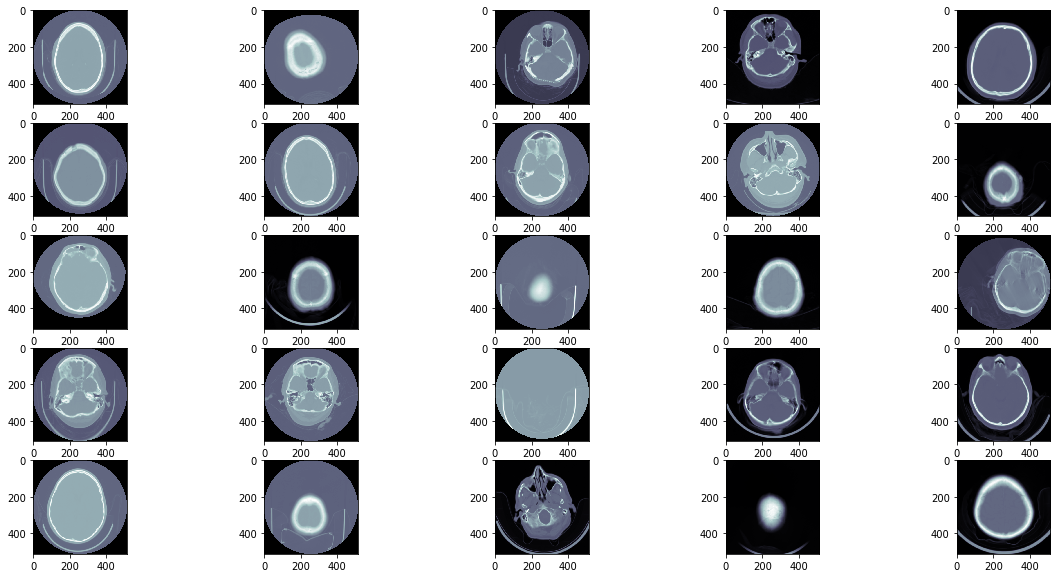

In [5]:
import matplotlib.image as pltimg
import pydicom

fig = plt.figure(figsize = (20,10))
rows = 5
columns = 5
trainImages = os.listdir('/kaggle/input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/')
for i in range(rows*columns):
    ds = pydicom.dcmread('/kaggle/input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/' + trainImages[i*100+1])
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

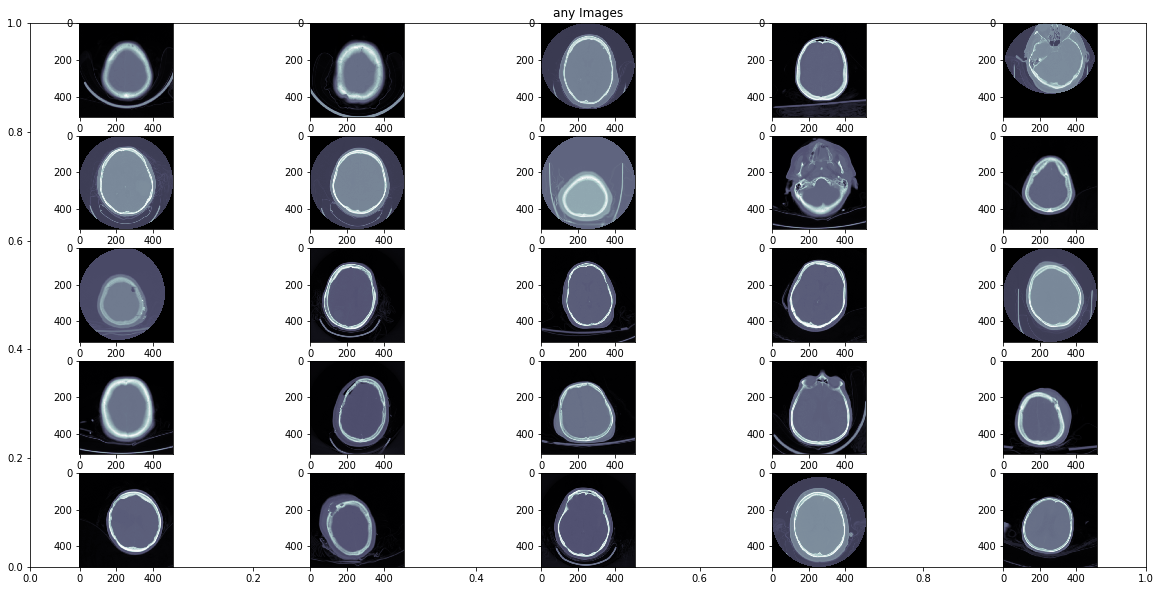

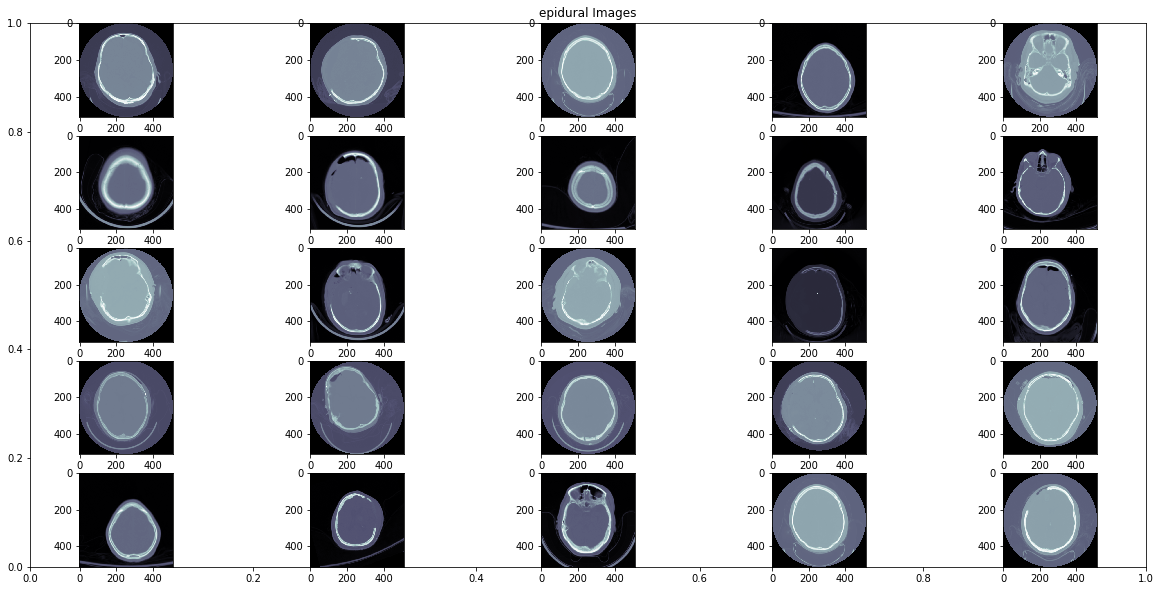

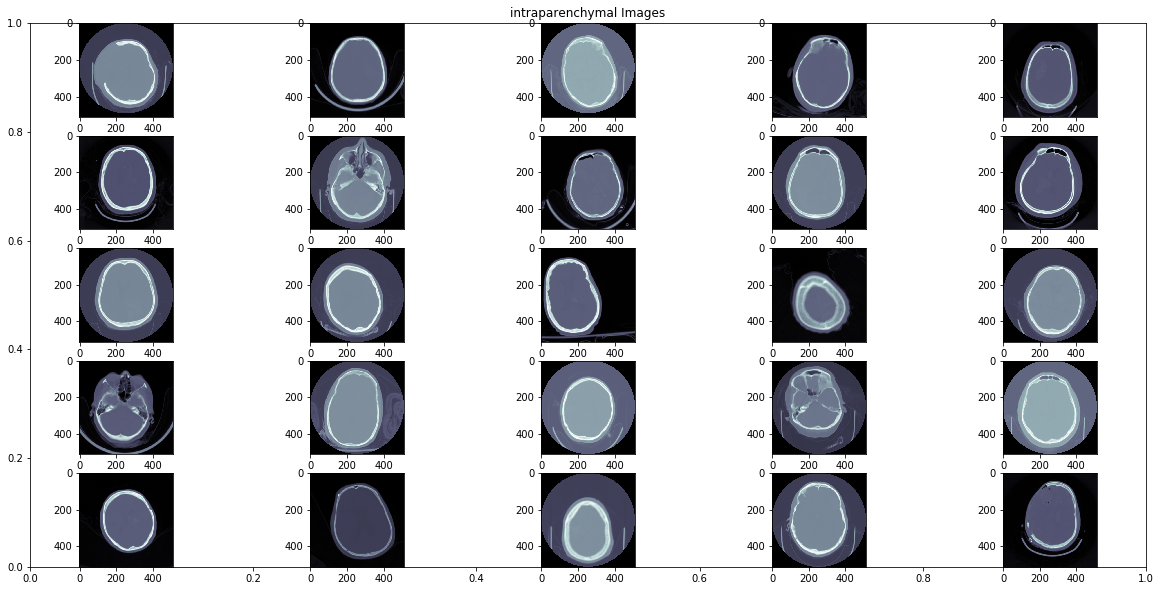

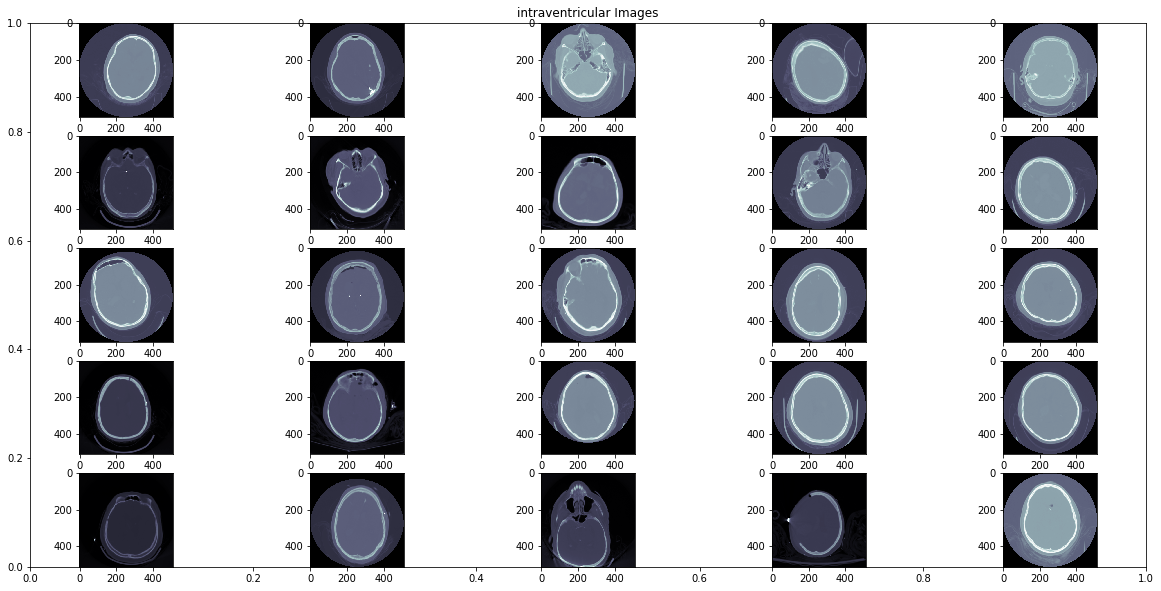

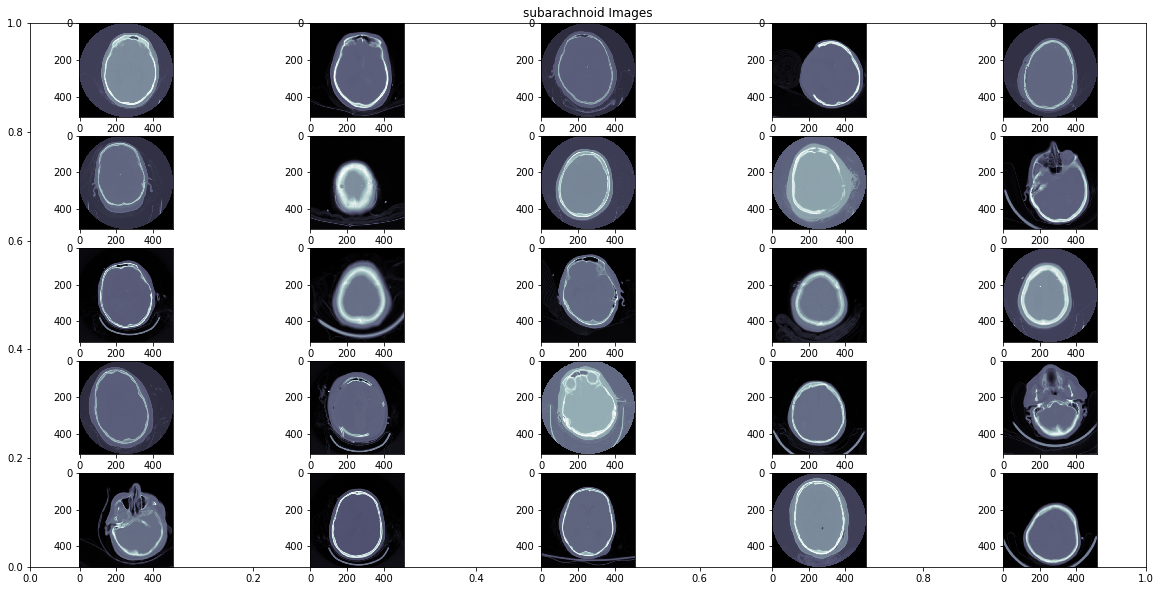

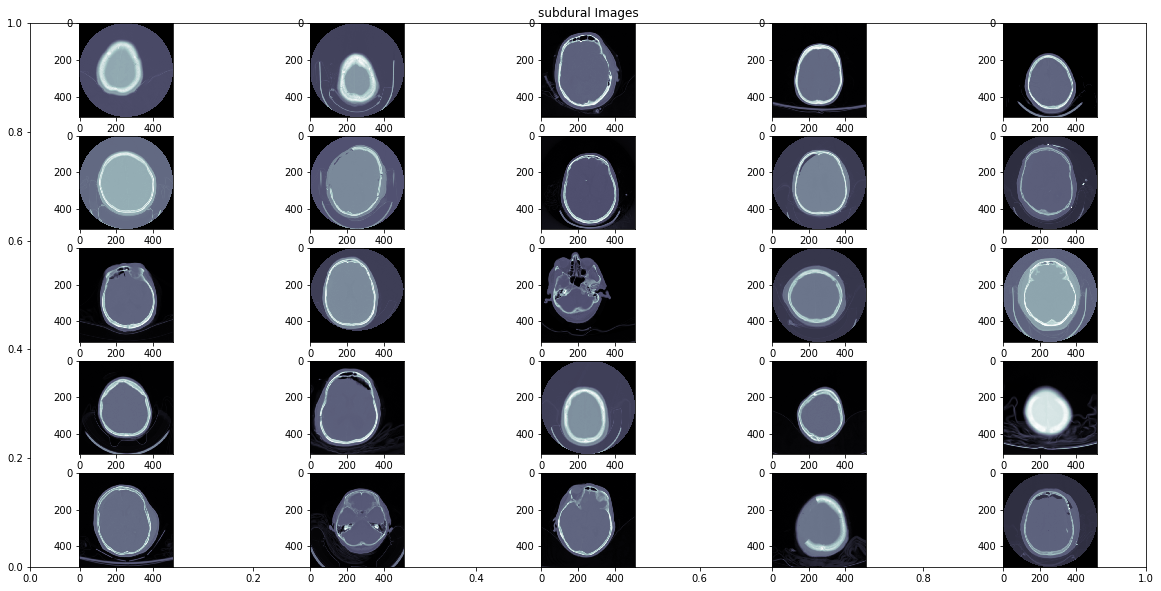

In [6]:
colsToPlot = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
rows = 5
columns = 5
for i_col in colsToPlot:
    fig = plt.figure(figsize = (20,10))
    trainImages = list(pivot_train_data.loc[pivot_train_data[i_col]==1,'fileName'])
    plt.title(i_col + ' Images')
    for i in range(rows*columns):
        ds = pydicom.dcmread('/kaggle/input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/' + trainImages[i*100+1] +'.dcm')
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)        
        fig.add_subplot

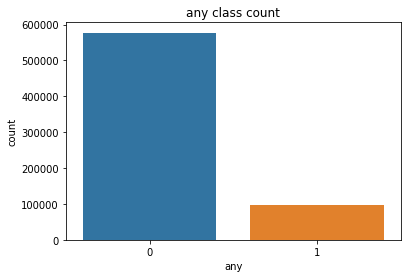

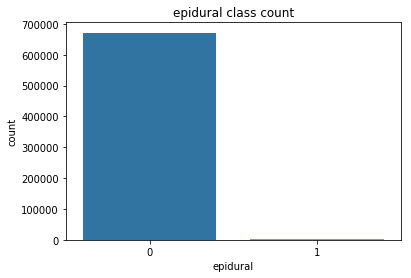

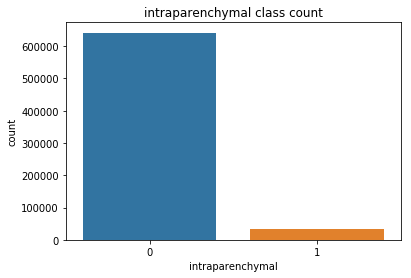

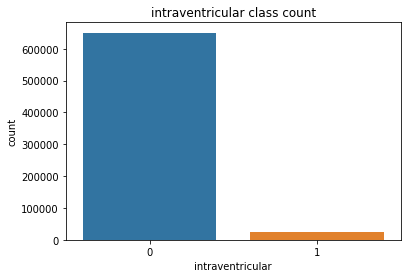

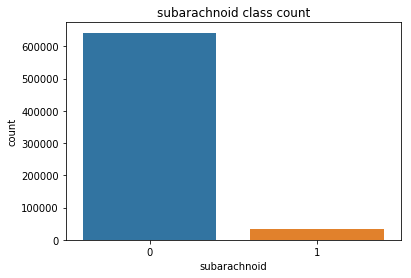

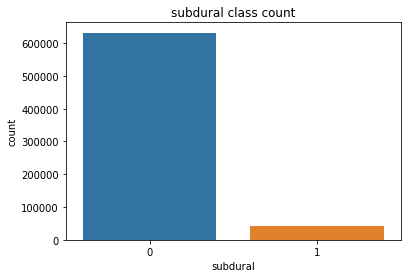

In [7]:
for i_col in colsToPlot:
    plt.figure()
    ax = sns.countplot(pivot_train_data[i_col])
    ax.set_title(i_col + ' class count')

In [8]:
# dropping of corrupted image from dataset
pivot_train_data = pivot_train_data.drop(list(pivot_train_data['fileName']).index('ID_6431af929'))

## Training Dataset

In [9]:
import keras
from keras.layers import Dense, Activation,Dropout,Conv2D,MaxPooling2D,Flatten,Input,BatchNormalization,AveragePooling2D,LeakyReLU,ZeroPadding2D,Add
from keras.models import Sequential, Model
from keras.initializers import glorot_uniform
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2

pivot_train_data = pivot_train_data.sample(frac=1).reset_index(drop=True)
train_df,val_df = train_test_split(pivot_train_data,test_size = 0.03, random_state = 42)
batch_size = 64

Using TensorFlow backend.


In [10]:
y_train = train_df[['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']]
y_val = val_df[['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']]
train_files = list(train_df['fileName'])

def readDCMFile(fileName):
    ds = pydicom.read_file(fileName) # read dicom image
    img = ds.pixel_array # get image array
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA) 
    return img

def generateImageData(train_files,y_train):
    numBatches = int(np.ceil(len(train_files)/batch_size))
    while True:
        for i in range(numBatches):
            batchFiles = train_files[i*batch_size : (i+1)*batch_size]
            x_batch_data = np.array([readDCMFile('/kaggle/input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/' + i_f +'.dcm') for i_f in tqdm(batchFiles)])
            y_batch_data = y_train[i*batch_size : (i+1)*batch_size]
            x_batch_data = np.reshape(x_batch_data,(x_batch_data.shape[0],x_batch_data.shape[1],x_batch_data.shape[2],1))            
            yield x_batch_data,y_batch_data
            
def generateTestImageData(test_files):
    numBatches = int(np.ceil(len(test_files)/batch_size))
    while True:
        for i in range(numBatches):
            batchFiles = test_files[i*batch_size : (i+1)*batch_size]
            x_batch_data = np.array([readDCMFile('/kaggle/input/rsna-intracranial-hemorrhage-detection/stage_1_test_images/' + i_f +'.dcm') for i_f in tqdm(batchFiles)])
            x_batch_data = np.reshape(x_batch_data,(x_batch_data.shape[0],x_batch_data.shape[1],x_batch_data.shape[2],1))
            yield x_batch_data

In [11]:
dataGenerator = generateImageData(train_files,train_df[colsToPlot])
val_files = list(val_df['fileName'])
x_val = np.array([readDCMFile('/kaggle/input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/' + i_f +'.dcm') for i_f in tqdm(val_files)])

100%|██████████| 20228/20228 [02:28<00:00, 136.62it/s]


In [12]:
y_val = val_df[colsToPlot]

## Loss Function Definition

In [13]:
# loss function definition courtesy https://www.kaggle.com/akensert/resnet50-keras-baseline-model
from keras import backend as K
def logloss(y_true,y_pred):      
    eps = K.epsilon()
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    #compute logloss function (vectorised)  
    out = -( y_true *K.log(y_pred)*class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred)*class_weights)
    return K.mean(out, axis=-1)

def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for the this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)

def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """      
    
    eps = K.epsilon()
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    y_pred = K.clip(y_pred, eps, 1.0-eps)
    loss = -(y_true*K.log(y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    loss_samples = _normalized_weighted_average(loss,class_weights)
    return K.mean(loss_samples)

## Defining Convolutional and Identity Block

In [14]:
def convolutionBlock(X,f,filters,stage,block,s):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    X_shortcut = X
    F1,F2,F3 = filters
    X = Conv2D(filters = F1, kernel_size = (1,1),strides = s, padding = 'valid',name = conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3,momentum=0.99, epsilon=0.001,name = bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = (f,f),strides = 1, padding = 'same',name = conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3,momentum=0.99, epsilon=0.001,name = bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F3, kernel_size = (1,1),strides = 1, padding = 'valid',name = conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3,momentum=0.99, epsilon=0.001,name = bn_name_base+'2c')(X)

    X_shortcut = Conv2D(filters = F3, kernel_size = (1,1),strides = s, padding = 'valid',name = conv_name_base + '1',
               kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3,momentum=0.99, epsilon=0.001,name = bn_name_base+'1')(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def identityBlock(X,f,filters,stage,block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    X_shortcut = X
    F1,F2,F3 = filters
    X = Conv2D(filters = F1, kernel_size = (1,1),strides = 1, padding = 'valid',name = conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3,momentum=0.99, epsilon=0.001,name = bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = (f,f),strides = 1, padding = 'same',name = conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3,momentum=0.99, epsilon=0.001,name = bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F3, kernel_size = (1,1),strides = 1, padding = 'valid',name = conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3,momentum=0.99, epsilon=0.001,name = bn_name_base+'2c')(X)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

## Convolutional Neural Network

In [15]:
input_img = Input((64,64,1))
X = Conv2D(filters=3, kernel_size=(1, 1), strides=(1, 1), name="initial_conv2d")(input_img)
X = BatchNormalization(axis=3, name='initial_bn')(X)
X = Activation('relu', name='initial_relu')(X)
X = ZeroPadding2D((3, 3))(X)

# Stage 1
X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

# Stage 2
X = convolutionBlock(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
X = identityBlock(X, 3, [64, 64, 256], stage=2, block='b')
X = identityBlock(X, 3, [64, 64, 256], stage=2, block='c')

# Stage 3 (≈4 lines)
X = convolutionBlock(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
X = identityBlock(X, 3, [128, 128, 512], stage=3, block='b')
X = identityBlock(X, 3, [128, 128, 512], stage=3, block='c')
X = identityBlock(X, 3, [128, 128, 512], stage=3, block='d')

# Stage 4 (≈4 lines)
X = convolutionBlock(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
X = identityBlock(X, 3, [256, 256, 1024], stage=4, block='b')
X = identityBlock(X, 3, [256, 256, 1024], stage=4, block='c')
X = identityBlock(X, 3, [256, 256, 1024], stage=4, block='d')
X = identityBlock(X, 3, [256, 256, 1024], stage=4, block='e')
X = identityBlock(X, 3, [256, 256, 1024], stage=4, block='f')

# Stage 5 (≈4 lines)
X = convolutionBlock(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
X = identityBlock(X, 3, [512, 512, 2048], stage=5, block='b')
X = identityBlock(X, 3, [512, 512, 2048], stage=5, block='c')


# AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
# output layer
X = Flatten()(X)
out = Dense(6,name='fc' + str(6),activation='sigmoid')(X)

### Reshape

In [16]:
x_val = np.reshape(x_val,(x_val.shape[0],x_val.shape[1],x_val.shape[2],1))

## Model

In [17]:
model_conv = Model(inputs = input_img, outputs = out)
model_conv.compile(optimizer='Adam',loss = logloss,metrics=[weighted_loss])
model_conv.summary()
history_conv = model_conv.fit_generator(dataGenerator,steps_per_epoch=500, epochs=20,validation_data = (x_val,y_val),verbose = False)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
initial_conv2d (Conv2D)         (None, 64, 64, 3)    6           input_1[0][0]                    
__________________________________________________________________________________________________
initial_bn (BatchNormalization) (None, 64, 64, 3)    12          initial_conv2d[0][0]             
__________________________________________________________________________________________________
initial_relu (Activation)       (None, 64, 64, 3)    0           initial_bn[0][0]                 
____________________________________________________________________________________________

  0%|          | 0/64 [00:00<?, ?it/s]

## Organizing data for Test Data

In [18]:
test_data = pd.read_csv('/kaggle/input/rsna-intracranial-hemorrhage-detection/stage_1_sample_submission.csv')
splitData = test_data['ID'].str.split('_', expand = True)
test_data['class'] = splitData[2]
test_data['fileName'] = splitData[0] + '_' + splitData[1]
test_data = test_data.drop(columns=['ID'],axis=1)
del splitData
pivot_test_data = test_data[['fileName','class','Label']].drop_duplicates().pivot_table(index = 'fileName',columns=['class'], values='Label')
pivot_test_data = pd.DataFrame(pivot_test_data.to_records())
test_files = list(pivot_test_data['fileName'])
testDataGenerator = generateTestImageData(test_files)
temp_pred = model_conv.predict_generator(testDataGenerator,steps = pivot_test_data.shape[0]/batch_size,verbose = True)

 55%|█████▍    | 35/64 [00:00<00:00, 110.47it/s]

   1/1227 [..............................] - ETA: 56:19

 70%|███████   | 45/64 [00:00<00:00, 105.82it/s]

   3/1227 [..............................] - ETA: 19:08

  0%|          | 0/64 [00:00<?, ?it/s]

   5/1227 [..............................] - ETA: 12:09

  0%|          | 0/64 [00:00<?, ?it/s]

   6/1227 [..............................] - ETA: 11:53

  0%|          | 0/64 [00:00<?, ?it/s]

   7/1227 [..............................] - ETA: 11:40

  0%|          | 0/64 [00:00<?, ?it/s]

   8/1227 [..............................] - ETA: 11:29

  0%|          | 0/64 [00:00<?, ?it/s]

   9/1227 [..............................] - ETA: 11:20

  0%|          | 0/64 [00:00<?, ?it/s]

  10/1227 [..............................] - ETA: 11:13

  0%|          | 0/64 [00:00<?, ?it/s]

  11/1227 [..............................] - ETA: 11:04

  0%|          | 0/64 [00:00<?, ?it/s]

  12/1227 [..............................] - ETA: 11:00

  0%|          | 0/64 [00:00<?, ?it/s]

  13/1227 [..............................] - ETA: 10:54

  0%|          | 0/64 [00:00<?, ?it/s]

  14/1227 [..............................] - ETA: 10:50

  0%|          | 0/64 [00:00<?, ?it/s]

  15/1227 [..............................] - ETA: 10:43

  0%|          | 0/64 [00:00<?, ?it/s]

  16/1227 [..............................] - ETA: 10:40

  0%|          | 0/64 [00:00<?, ?it/s]

  17/1227 [..............................] - ETA: 10:35

  0%|          | 0/64 [00:00<?, ?it/s]

  18/1227 [..............................] - ETA: 10:31

  0%|          | 0/64 [00:00<?, ?it/s]

  19/1227 [..............................] - ETA: 10:26

  0%|          | 0/64 [00:00<?, ?it/s]

  20/1227 [..............................] - ETA: 10:24

  0%|          | 0/64 [00:00<?, ?it/s]

  21/1227 [..............................] - ETA: 10:20

  0%|          | 0/64 [00:00<?, ?it/s]

  22/1227 [..............................] - ETA: 10:18

  0%|          | 0/64 [00:00<?, ?it/s]

  23/1227 [..............................] - ETA: 10:16

  0%|          | 0/64 [00:00<?, ?it/s]

  24/1227 [..............................] - ETA: 10:16

  0%|          | 0/64 [00:00<?, ?it/s]

  25/1227 [..............................] - ETA: 10:14

  0%|          | 0/64 [00:00<?, ?it/s]

  26/1227 [..............................] - ETA: 10:14

  0%|          | 0/64 [00:00<?, ?it/s]

  27/1227 [..............................] - ETA: 10:13

  0%|          | 0/64 [00:00<?, ?it/s]

  28/1227 [..............................] - ETA: 10:12

  0%|          | 0/64 [00:00<?, ?it/s]

  29/1227 [..............................] - ETA: 10:10

  0%|          | 0/64 [00:00<?, ?it/s]

  30/1227 [..............................] - ETA: 10:08

  0%|          | 0/64 [00:00<?, ?it/s]

  31/1227 [..............................] - ETA: 10:07

  0%|          | 0/64 [00:00<?, ?it/s]

  32/1227 [..............................] - ETA: 10:05

  0%|          | 0/64 [00:00<?, ?it/s]

  33/1227 [..............................] - ETA: 10:04

  0%|          | 0/64 [00:00<?, ?it/s]

  34/1227 [..............................] - ETA: 10:03

  0%|          | 0/64 [00:00<?, ?it/s]

  35/1227 [..............................] - ETA: 10:03

  0%|          | 0/64 [00:00<?, ?it/s]

  36/1227 [..............................] - ETA: 10:00

  0%|          | 0/64 [00:00<?, ?it/s]

  37/1227 [..............................] - ETA: 9:58 

  0%|          | 0/64 [00:00<?, ?it/s]

  38/1227 [..............................] - ETA: 9:56

  0%|          | 0/64 [00:00<?, ?it/s]

  39/1227 [..............................] - ETA: 9:55

  0%|          | 0/64 [00:00<?, ?it/s]

  40/1227 [..............................] - ETA: 9:54

  0%|          | 0/64 [00:00<?, ?it/s]

  41/1227 [>.............................] - ETA: 9:53

  0%|          | 0/64 [00:00<?, ?it/s]

  42/1227 [>.............................] - ETA: 9:52

  0%|          | 0/64 [00:00<?, ?it/s]

  43/1227 [>.............................] - ETA: 9:51

  0%|          | 0/64 [00:00<?, ?it/s]

  44/1227 [>.............................] - ETA: 9:50

  0%|          | 0/64 [00:00<?, ?it/s]

  45/1227 [>.............................] - ETA: 9:49

  0%|          | 0/64 [00:00<?, ?it/s]

  46/1227 [>.............................] - ETA: 9:48

  0%|          | 0/64 [00:00<?, ?it/s]

  47/1227 [>.............................] - ETA: 9:47

  0%|          | 0/64 [00:00<?, ?it/s]

  48/1227 [>.............................] - ETA: 9:46

  0%|          | 0/64 [00:00<?, ?it/s]

  49/1227 [>.............................] - ETA: 9:46

  0%|          | 0/64 [00:00<?, ?it/s]

  50/1227 [>.............................] - ETA: 9:45

  0%|          | 0/64 [00:00<?, ?it/s]

  51/1227 [>.............................] - ETA: 9:44

  0%|          | 0/64 [00:00<?, ?it/s]

  52/1227 [>.............................] - ETA: 9:44

  0%|          | 0/64 [00:00<?, ?it/s]

  53/1227 [>.............................] - ETA: 9:43

  0%|          | 0/64 [00:00<?, ?it/s]

  54/1227 [>.............................] - ETA: 9:42

  0%|          | 0/64 [00:00<?, ?it/s]

  55/1227 [>.............................] - ETA: 9:41

  0%|          | 0/64 [00:00<?, ?it/s]

  56/1227 [>.............................] - ETA: 9:40

  0%|          | 0/64 [00:00<?, ?it/s]

  57/1227 [>.............................] - ETA: 9:39

  0%|          | 0/64 [00:00<?, ?it/s]

  58/1227 [>.............................] - ETA: 9:38

  0%|          | 0/64 [00:00<?, ?it/s]

  59/1227 [>.............................] - ETA: 9:38

  0%|          | 0/64 [00:00<?, ?it/s]

  60/1227 [>.............................] - ETA: 9:37

  0%|          | 0/64 [00:00<?, ?it/s]

  61/1227 [>.............................] - ETA: 9:36

  0%|          | 0/64 [00:00<?, ?it/s]

  62/1227 [>.............................] - ETA: 9:35

  0%|          | 0/64 [00:00<?, ?it/s]

  63/1227 [>.............................] - ETA: 9:35

  0%|          | 0/64 [00:00<?, ?it/s]

  64/1227 [>.............................] - ETA: 9:34

  0%|          | 0/64 [00:00<?, ?it/s]

  65/1227 [>.............................] - ETA: 9:33

  0%|          | 0/64 [00:00<?, ?it/s]

  66/1227 [>.............................] - ETA: 9:33

  0%|          | 0/64 [00:00<?, ?it/s]

  67/1227 [>.............................] - ETA: 9:32

  0%|          | 0/64 [00:00<?, ?it/s]

  68/1227 [>.............................] - ETA: 9:31

  0%|          | 0/64 [00:00<?, ?it/s]

  69/1227 [>.............................] - ETA: 9:30

  0%|          | 0/64 [00:00<?, ?it/s]

  70/1227 [>.............................] - ETA: 9:30

  0%|          | 0/64 [00:00<?, ?it/s]

  71/1227 [>.............................] - ETA: 9:29

  0%|          | 0/64 [00:00<?, ?it/s]

  72/1227 [>.............................] - ETA: 9:28

  0%|          | 0/64 [00:00<?, ?it/s]

  73/1227 [>.............................] - ETA: 9:27

  0%|          | 0/64 [00:00<?, ?it/s]

  74/1227 [>.............................] - ETA: 9:27

  0%|          | 0/64 [00:00<?, ?it/s]

  75/1227 [>.............................] - ETA: 9:26

  0%|          | 0/64 [00:00<?, ?it/s]

  76/1227 [>.............................] - ETA: 9:25

  0%|          | 0/64 [00:00<?, ?it/s]

  77/1227 [>.............................] - ETA: 9:25

  0%|          | 0/64 [00:00<?, ?it/s]

  78/1227 [>.............................] - ETA: 9:24

  0%|          | 0/64 [00:00<?, ?it/s]

  79/1227 [>.............................] - ETA: 9:24

  0%|          | 0/64 [00:00<?, ?it/s]

  80/1227 [>.............................] - ETA: 9:23

  0%|          | 0/64 [00:00<?, ?it/s]

  81/1227 [>.............................] - ETA: 9:23

  0%|          | 0/64 [00:00<?, ?it/s]

  82/1227 [=>............................] - ETA: 9:22

  0%|          | 0/64 [00:00<?, ?it/s]

  83/1227 [=>............................] - ETA: 9:22

  0%|          | 0/64 [00:00<?, ?it/s]

  84/1227 [=>............................] - ETA: 9:21

  0%|          | 0/64 [00:00<?, ?it/s]

  85/1227 [=>............................] - ETA: 9:21

  0%|          | 0/64 [00:00<?, ?it/s]

  86/1227 [=>............................] - ETA: 9:20

  0%|          | 0/64 [00:00<?, ?it/s]

  87/1227 [=>............................] - ETA: 9:20

  0%|          | 0/64 [00:00<?, ?it/s]

  88/1227 [=>............................] - ETA: 9:19

  0%|          | 0/64 [00:00<?, ?it/s]

  89/1227 [=>............................] - ETA: 9:19

  0%|          | 0/64 [00:00<?, ?it/s]

  90/1227 [=>............................] - ETA: 9:18

  0%|          | 0/64 [00:00<?, ?it/s]

  91/1227 [=>............................] - ETA: 9:18

  0%|          | 0/64 [00:00<?, ?it/s]

  92/1227 [=>............................] - ETA: 9:17

  0%|          | 0/64 [00:00<?, ?it/s]

  93/1227 [=>............................] - ETA: 9:17

  0%|          | 0/64 [00:00<?, ?it/s]

  94/1227 [=>............................] - ETA: 9:16

  0%|          | 0/64 [00:00<?, ?it/s]

  95/1227 [=>............................] - ETA: 9:16

  0%|          | 0/64 [00:00<?, ?it/s]

  96/1227 [=>............................] - ETA: 9:15

  0%|          | 0/64 [00:00<?, ?it/s]

  97/1227 [=>............................] - ETA: 9:14

  0%|          | 0/64 [00:00<?, ?it/s]

  98/1227 [=>............................] - ETA: 9:14

  0%|          | 0/64 [00:00<?, ?it/s]

  99/1227 [=>............................] - ETA: 9:13

  0%|          | 0/64 [00:00<?, ?it/s]

 100/1227 [=>............................] - ETA: 9:13

  0%|          | 0/64 [00:00<?, ?it/s]

 101/1227 [=>............................] - ETA: 9:12

  0%|          | 0/64 [00:00<?, ?it/s]

 102/1227 [=>............................] - ETA: 9:12

  0%|          | 0/64 [00:00<?, ?it/s]

 103/1227 [=>............................] - ETA: 9:11

  0%|          | 0/64 [00:00<?, ?it/s]

 104/1227 [=>............................] - ETA: 9:11

  0%|          | 0/64 [00:00<?, ?it/s]

 105/1227 [=>............................] - ETA: 9:10

  0%|          | 0/64 [00:00<?, ?it/s]

 106/1227 [=>............................] - ETA: 9:10

  0%|          | 0/64 [00:00<?, ?it/s]

 107/1227 [=>............................] - ETA: 9:09

  0%|          | 0/64 [00:00<?, ?it/s]

 108/1227 [=>............................] - ETA: 9:09

  0%|          | 0/64 [00:00<?, ?it/s]

 109/1227 [=>............................] - ETA: 9:08

  0%|          | 0/64 [00:00<?, ?it/s]

 110/1227 [=>............................] - ETA: 9:08

  0%|          | 0/64 [00:00<?, ?it/s]

 111/1227 [=>............................] - ETA: 9:08

  0%|          | 0/64 [00:00<?, ?it/s]

 112/1227 [=>............................] - ETA: 9:07

  0%|          | 0/64 [00:00<?, ?it/s]

 113/1227 [=>............................] - ETA: 9:07

  0%|          | 0/64 [00:00<?, ?it/s]

 114/1227 [=>............................] - ETA: 9:06

  0%|          | 0/64 [00:00<?, ?it/s]

 115/1227 [=>............................] - ETA: 9:06

  0%|          | 0/64 [00:00<?, ?it/s]

 116/1227 [=>............................] - ETA: 9:06

  0%|          | 0/64 [00:00<?, ?it/s]

 117/1227 [=>............................] - ETA: 9:05

  0%|          | 0/64 [00:00<?, ?it/s]

 118/1227 [=>............................] - ETA: 9:05

  0%|          | 0/64 [00:00<?, ?it/s]

 119/1227 [=>............................] - ETA: 9:05

  0%|          | 0/64 [00:00<?, ?it/s]

 120/1227 [=>............................] - ETA: 9:05

  0%|          | 0/64 [00:00<?, ?it/s]

 121/1227 [=>............................] - ETA: 9:05

  0%|          | 0/64 [00:00<?, ?it/s]

 122/1227 [=>............................] - ETA: 9:05

  0%|          | 0/64 [00:00<?, ?it/s]

 123/1227 [==>...........................] - ETA: 9:05

  0%|          | 0/64 [00:00<?, ?it/s]

 124/1227 [==>...........................] - ETA: 9:05

  0%|          | 0/64 [00:00<?, ?it/s]

 125/1227 [==>...........................] - ETA: 9:04

  0%|          | 0/64 [00:00<?, ?it/s]

 126/1227 [==>...........................] - ETA: 9:04

  0%|          | 0/64 [00:00<?, ?it/s]

 127/1227 [==>...........................] - ETA: 9:04

  0%|          | 0/64 [00:00<?, ?it/s]

 128/1227 [==>...........................] - ETA: 9:04

  0%|          | 0/64 [00:00<?, ?it/s]

 129/1227 [==>...........................] - ETA: 9:04

  0%|          | 0/64 [00:00<?, ?it/s]

 130/1227 [==>...........................] - ETA: 9:04

  0%|          | 0/64 [00:00<?, ?it/s]

 131/1227 [==>...........................] - ETA: 9:03

  0%|          | 0/64 [00:00<?, ?it/s]

 132/1227 [==>...........................] - ETA: 9:03

  0%|          | 0/64 [00:00<?, ?it/s]

 133/1227 [==>...........................] - ETA: 9:03

  0%|          | 0/64 [00:00<?, ?it/s]

 134/1227 [==>...........................] - ETA: 9:03

  0%|          | 0/64 [00:00<?, ?it/s]

 135/1227 [==>...........................] - ETA: 9:03

  0%|          | 0/64 [00:00<?, ?it/s]

 136/1227 [==>...........................] - ETA: 9:03

  0%|          | 0/64 [00:00<?, ?it/s]

 137/1227 [==>...........................] - ETA: 9:02

  0%|          | 0/64 [00:00<?, ?it/s]

 138/1227 [==>...........................] - ETA: 9:02

  0%|          | 0/64 [00:00<?, ?it/s]

 139/1227 [==>...........................] - ETA: 9:02

  0%|          | 0/64 [00:00<?, ?it/s]

 140/1227 [==>...........................] - ETA: 9:01

  0%|          | 0/64 [00:00<?, ?it/s]

 141/1227 [==>...........................] - ETA: 9:01

  0%|          | 0/64 [00:00<?, ?it/s]

 142/1227 [==>...........................] - ETA: 9:01

  0%|          | 0/64 [00:00<?, ?it/s]

 143/1227 [==>...........................] - ETA: 9:01

  0%|          | 0/64 [00:00<?, ?it/s]

 144/1227 [==>...........................] - ETA: 9:00

  0%|          | 0/64 [00:00<?, ?it/s]

 145/1227 [==>...........................] - ETA: 8:59

  0%|          | 0/64 [00:00<?, ?it/s]

 146/1227 [==>...........................] - ETA: 8:59

  0%|          | 0/64 [00:00<?, ?it/s]

 147/1227 [==>...........................] - ETA: 8:59

  0%|          | 0/64 [00:00<?, ?it/s]

 148/1227 [==>...........................] - ETA: 8:58

  0%|          | 0/64 [00:00<?, ?it/s]

 149/1227 [==>...........................] - ETA: 8:58

  0%|          | 0/64 [00:00<?, ?it/s]

 150/1227 [==>...........................] - ETA: 8:57

  0%|          | 0/64 [00:00<?, ?it/s]

 151/1227 [==>...........................] - ETA: 8:57

  0%|          | 0/64 [00:00<?, ?it/s]

 152/1227 [==>...........................] - ETA: 8:56

  0%|          | 0/64 [00:00<?, ?it/s]

 153/1227 [==>...........................] - ETA: 8:56

  0%|          | 0/64 [00:00<?, ?it/s]

 154/1227 [==>...........................] - ETA: 8:55

  0%|          | 0/64 [00:00<?, ?it/s]

 155/1227 [==>...........................] - ETA: 8:55

  0%|          | 0/64 [00:00<?, ?it/s]

 156/1227 [==>...........................] - ETA: 8:55

  0%|          | 0/64 [00:00<?, ?it/s]

 157/1227 [==>...........................] - ETA: 8:54

  0%|          | 0/64 [00:00<?, ?it/s]

 158/1227 [==>...........................] - ETA: 8:54

  0%|          | 0/64 [00:00<?, ?it/s]

 159/1227 [==>...........................] - ETA: 8:53

  0%|          | 0/64 [00:00<?, ?it/s]

 160/1227 [==>...........................] - ETA: 8:53

  0%|          | 0/64 [00:00<?, ?it/s]

 161/1227 [==>...........................] - ETA: 8:53

  0%|          | 0/64 [00:00<?, ?it/s]

 162/1227 [==>...........................] - ETA: 8:52

  0%|          | 0/64 [00:00<?, ?it/s]

 163/1227 [==>...........................] - ETA: 8:52

  0%|          | 0/64 [00:00<?, ?it/s]

 164/1227 [===>..........................] - ETA: 8:51

  0%|          | 0/64 [00:00<?, ?it/s]

 165/1227 [===>..........................] - ETA: 8:51

  0%|          | 0/64 [00:00<?, ?it/s]

 166/1227 [===>..........................] - ETA: 8:50

  0%|          | 0/64 [00:00<?, ?it/s]

 167/1227 [===>..........................] - ETA: 8:50

  0%|          | 0/64 [00:00<?, ?it/s]

 168/1227 [===>..........................] - ETA: 8:49

  0%|          | 0/64 [00:00<?, ?it/s]

 169/1227 [===>..........................] - ETA: 8:49

  0%|          | 0/64 [00:00<?, ?it/s]

 170/1227 [===>..........................] - ETA: 8:48

  0%|          | 0/64 [00:00<?, ?it/s]

 171/1227 [===>..........................] - ETA: 8:48

  0%|          | 0/64 [00:00<?, ?it/s]

 172/1227 [===>..........................] - ETA: 8:47

  0%|          | 0/64 [00:00<?, ?it/s]

 173/1227 [===>..........................] - ETA: 8:47

  0%|          | 0/64 [00:00<?, ?it/s]

 174/1227 [===>..........................] - ETA: 8:47

  0%|          | 0/64 [00:00<?, ?it/s]

 175/1227 [===>..........................] - ETA: 8:46

  0%|          | 0/64 [00:00<?, ?it/s]

 176/1227 [===>..........................] - ETA: 8:46

  0%|          | 0/64 [00:00<?, ?it/s]

 177/1227 [===>..........................] - ETA: 8:46

  0%|          | 0/64 [00:00<?, ?it/s]

 178/1227 [===>..........................] - ETA: 8:45

  0%|          | 0/64 [00:00<?, ?it/s]

 179/1227 [===>..........................] - ETA: 8:45

  0%|          | 0/64 [00:00<?, ?it/s]

 180/1227 [===>..........................] - ETA: 8:45

  0%|          | 0/64 [00:00<?, ?it/s]

 181/1227 [===>..........................] - ETA: 8:44

  0%|          | 0/64 [00:00<?, ?it/s]

 182/1227 [===>..........................] - ETA: 8:44

  0%|          | 0/64 [00:00<?, ?it/s]

 183/1227 [===>..........................] - ETA: 8:44

  0%|          | 0/64 [00:00<?, ?it/s]

 184/1227 [===>..........................] - ETA: 8:43

  0%|          | 0/64 [00:00<?, ?it/s]

 185/1227 [===>..........................] - ETA: 8:43

  0%|          | 0/64 [00:00<?, ?it/s]

 186/1227 [===>..........................] - ETA: 8:42

  0%|          | 0/64 [00:00<?, ?it/s]

 187/1227 [===>..........................] - ETA: 8:42

  0%|          | 0/64 [00:00<?, ?it/s]

 188/1227 [===>..........................] - ETA: 8:41

  0%|          | 0/64 [00:00<?, ?it/s]

 189/1227 [===>..........................] - ETA: 8:41

  0%|          | 0/64 [00:00<?, ?it/s]

 190/1227 [===>..........................] - ETA: 8:40

  0%|          | 0/64 [00:00<?, ?it/s]

 191/1227 [===>..........................] - ETA: 8:40

  0%|          | 0/64 [00:00<?, ?it/s]

 192/1227 [===>..........................] - ETA: 8:39

  0%|          | 0/64 [00:00<?, ?it/s]

 193/1227 [===>..........................] - ETA: 8:39

  0%|          | 0/64 [00:00<?, ?it/s]

 194/1227 [===>..........................] - ETA: 8:38

  0%|          | 0/64 [00:00<?, ?it/s]

 195/1227 [===>..........................] - ETA: 8:38

  0%|          | 0/64 [00:00<?, ?it/s]

 196/1227 [===>..........................] - ETA: 8:37

  0%|          | 0/64 [00:00<?, ?it/s]

 197/1227 [===>..........................] - ETA: 8:37

  0%|          | 0/64 [00:00<?, ?it/s]

 198/1227 [===>..........................] - ETA: 8:36

  0%|          | 0/64 [00:00<?, ?it/s]

 199/1227 [===>..........................] - ETA: 8:36

  0%|          | 0/64 [00:00<?, ?it/s]

 200/1227 [===>..........................] - ETA: 8:35

  0%|          | 0/64 [00:00<?, ?it/s]

 201/1227 [===>..........................] - ETA: 8:35

  0%|          | 0/64 [00:00<?, ?it/s]

 202/1227 [===>..........................] - ETA: 8:34

  0%|          | 0/64 [00:00<?, ?it/s]

 203/1227 [===>..........................] - ETA: 8:34

  0%|          | 0/64 [00:00<?, ?it/s]

 204/1227 [===>..........................] - ETA: 8:34

  0%|          | 0/64 [00:00<?, ?it/s]

 205/1227 [====>.........................] - ETA: 8:33

  0%|          | 0/64 [00:00<?, ?it/s]

 206/1227 [====>.........................] - ETA: 8:33

  0%|          | 0/64 [00:00<?, ?it/s]

 207/1227 [====>.........................] - ETA: 8:32

  0%|          | 0/64 [00:00<?, ?it/s]

 208/1227 [====>.........................] - ETA: 8:32

  0%|          | 0/64 [00:00<?, ?it/s]

 209/1227 [====>.........................] - ETA: 8:31

  0%|          | 0/64 [00:00<?, ?it/s]

 210/1227 [====>.........................] - ETA: 8:31

  0%|          | 0/64 [00:00<?, ?it/s]

 211/1227 [====>.........................] - ETA: 8:30

  0%|          | 0/64 [00:00<?, ?it/s]

 212/1227 [====>.........................] - ETA: 8:29

  0%|          | 0/64 [00:00<?, ?it/s]

 213/1227 [====>.........................] - ETA: 8:29

  0%|          | 0/64 [00:00<?, ?it/s]

 214/1227 [====>.........................] - ETA: 8:29

  0%|          | 0/64 [00:00<?, ?it/s]

 215/1227 [====>.........................] - ETA: 8:28

  0%|          | 0/64 [00:00<?, ?it/s]

 216/1227 [====>.........................] - ETA: 8:28

  0%|          | 0/64 [00:00<?, ?it/s]

 217/1227 [====>.........................] - ETA: 8:27

  0%|          | 0/64 [00:00<?, ?it/s]

 218/1227 [====>.........................] - ETA: 8:27

  0%|          | 0/64 [00:00<?, ?it/s]

 219/1227 [====>.........................] - ETA: 8:26

  0%|          | 0/64 [00:00<?, ?it/s]

 220/1227 [====>.........................] - ETA: 8:26

  0%|          | 0/64 [00:00<?, ?it/s]

 221/1227 [====>.........................] - ETA: 8:25

  0%|          | 0/64 [00:00<?, ?it/s]

 222/1227 [====>.........................] - ETA: 8:25

  0%|          | 0/64 [00:00<?, ?it/s]

 223/1227 [====>.........................] - ETA: 8:24

  0%|          | 0/64 [00:00<?, ?it/s]

 224/1227 [====>.........................] - ETA: 8:24

  0%|          | 0/64 [00:00<?, ?it/s]

 225/1227 [====>.........................] - ETA: 8:23

  0%|          | 0/64 [00:00<?, ?it/s]

 226/1227 [====>.........................] - ETA: 8:23

  0%|          | 0/64 [00:00<?, ?it/s]

 227/1227 [====>.........................] - ETA: 8:22

  0%|          | 0/64 [00:00<?, ?it/s]

 228/1227 [====>.........................] - ETA: 8:22

  0%|          | 0/64 [00:00<?, ?it/s]

 229/1227 [====>.........................] - ETA: 8:21

  0%|          | 0/64 [00:00<?, ?it/s]

 230/1227 [====>.........................] - ETA: 8:21

  0%|          | 0/64 [00:00<?, ?it/s]

 231/1227 [====>.........................] - ETA: 8:21

  0%|          | 0/64 [00:00<?, ?it/s]

 232/1227 [====>.........................] - ETA: 8:20

  0%|          | 0/64 [00:00<?, ?it/s]

 233/1227 [====>.........................] - ETA: 8:20

  0%|          | 0/64 [00:00<?, ?it/s]

 234/1227 [====>.........................] - ETA: 8:19

  0%|          | 0/64 [00:00<?, ?it/s]

 235/1227 [====>.........................] - ETA: 8:19

  0%|          | 0/64 [00:00<?, ?it/s]

 236/1227 [====>.........................] - ETA: 8:18

  0%|          | 0/64 [00:00<?, ?it/s]

 237/1227 [====>.........................] - ETA: 8:18

  0%|          | 0/64 [00:00<?, ?it/s]

 238/1227 [====>.........................] - ETA: 8:18

  0%|          | 0/64 [00:00<?, ?it/s]

 239/1227 [====>.........................] - ETA: 8:17

  0%|          | 0/64 [00:00<?, ?it/s]

 240/1227 [====>.........................] - ETA: 8:17

  0%|          | 0/64 [00:00<?, ?it/s]

 241/1227 [====>.........................] - ETA: 8:17

  0%|          | 0/64 [00:00<?, ?it/s]

 242/1227 [====>.........................] - ETA: 8:16

  0%|          | 0/64 [00:00<?, ?it/s]

 243/1227 [====>.........................] - ETA: 8:16

  0%|          | 0/64 [00:00<?, ?it/s]

 244/1227 [====>.........................] - ETA: 8:15

  0%|          | 0/64 [00:00<?, ?it/s]

 245/1227 [====>.........................] - ETA: 8:15

  0%|          | 0/64 [00:00<?, ?it/s]

 246/1227 [=====>........................] - ETA: 8:14

  0%|          | 0/64 [00:00<?, ?it/s]

 247/1227 [=====>........................] - ETA: 8:14

  0%|          | 0/64 [00:00<?, ?it/s]

 248/1227 [=====>........................] - ETA: 8:14

  0%|          | 0/64 [00:00<?, ?it/s]

 249/1227 [=====>........................] - ETA: 8:13

  0%|          | 0/64 [00:00<?, ?it/s]

 250/1227 [=====>........................] - ETA: 8:13

  0%|          | 0/64 [00:00<?, ?it/s]

 251/1227 [=====>........................] - ETA: 8:13

  0%|          | 0/64 [00:00<?, ?it/s]

 252/1227 [=====>........................] - ETA: 8:13

  0%|          | 0/64 [00:00<?, ?it/s]

 253/1227 [=====>........................] - ETA: 8:12

  0%|          | 0/64 [00:00<?, ?it/s]

 254/1227 [=====>........................] - ETA: 8:12

  0%|          | 0/64 [00:00<?, ?it/s]

 255/1227 [=====>........................] - ETA: 8:11

  0%|          | 0/64 [00:00<?, ?it/s]

 256/1227 [=====>........................] - ETA: 8:11

  0%|          | 0/64 [00:00<?, ?it/s]

 257/1227 [=====>........................] - ETA: 8:10

  0%|          | 0/64 [00:00<?, ?it/s]

 258/1227 [=====>........................] - ETA: 8:10

  0%|          | 0/64 [00:00<?, ?it/s]

 259/1227 [=====>........................] - ETA: 8:09

  0%|          | 0/64 [00:00<?, ?it/s]

 260/1227 [=====>........................] - ETA: 8:08

  0%|          | 0/64 [00:00<?, ?it/s]

 261/1227 [=====>........................] - ETA: 8:08

  0%|          | 0/64 [00:00<?, ?it/s]

 262/1227 [=====>........................] - ETA: 8:07

  0%|          | 0/64 [00:00<?, ?it/s]

 263/1227 [=====>........................] - ETA: 8:07

  0%|          | 0/64 [00:00<?, ?it/s]

 264/1227 [=====>........................] - ETA: 8:06

  0%|          | 0/64 [00:00<?, ?it/s]

 265/1227 [=====>........................] - ETA: 8:06

  0%|          | 0/64 [00:00<?, ?it/s]

 266/1227 [=====>........................] - ETA: 8:05

  0%|          | 0/64 [00:00<?, ?it/s]

 267/1227 [=====>........................] - ETA: 8:05

  0%|          | 0/64 [00:00<?, ?it/s]

 268/1227 [=====>........................] - ETA: 8:04

  0%|          | 0/64 [00:00<?, ?it/s]

 269/1227 [=====>........................] - ETA: 8:04

  0%|          | 0/64 [00:00<?, ?it/s]

 270/1227 [=====>........................] - ETA: 8:03

  0%|          | 0/64 [00:00<?, ?it/s]

 271/1227 [=====>........................] - ETA: 8:03

  0%|          | 0/64 [00:00<?, ?it/s]

 272/1227 [=====>........................] - ETA: 8:02

  0%|          | 0/64 [00:00<?, ?it/s]

 273/1227 [=====>........................] - ETA: 8:02

  0%|          | 0/64 [00:00<?, ?it/s]

 274/1227 [=====>........................] - ETA: 8:01

  0%|          | 0/64 [00:00<?, ?it/s]

 275/1227 [=====>........................] - ETA: 8:01

  0%|          | 0/64 [00:00<?, ?it/s]

 276/1227 [=====>........................] - ETA: 8:00

  0%|          | 0/64 [00:00<?, ?it/s]

 277/1227 [=====>........................] - ETA: 8:00

  0%|          | 0/64 [00:00<?, ?it/s]

 278/1227 [=====>........................] - ETA: 7:59

  0%|          | 0/64 [00:00<?, ?it/s]

 279/1227 [=====>........................] - ETA: 7:59

  0%|          | 0/64 [00:00<?, ?it/s]

 280/1227 [=====>........................] - ETA: 7:58

  0%|          | 0/64 [00:00<?, ?it/s]

 281/1227 [=====>........................] - ETA: 7:58

  0%|          | 0/64 [00:00<?, ?it/s]

 282/1227 [=====>........................] - ETA: 7:57

  0%|          | 0/64 [00:00<?, ?it/s]

 283/1227 [=====>........................] - ETA: 7:57

  0%|          | 0/64 [00:00<?, ?it/s]

 284/1227 [=====>........................] - ETA: 7:56

  0%|          | 0/64 [00:00<?, ?it/s]

 285/1227 [=====>........................] - ETA: 7:56

  0%|          | 0/64 [00:00<?, ?it/s]

 286/1227 [=====>........................] - ETA: 7:55

  0%|          | 0/64 [00:00<?, ?it/s]

 287/1227 [======>.......................] - ETA: 7:55

  0%|          | 0/64 [00:00<?, ?it/s]

 288/1227 [======>.......................] - ETA: 7:54

  0%|          | 0/64 [00:00<?, ?it/s]

 289/1227 [======>.......................] - ETA: 7:54

  0%|          | 0/64 [00:00<?, ?it/s]

 290/1227 [======>.......................] - ETA: 7:53

  0%|          | 0/64 [00:00<?, ?it/s]

 291/1227 [======>.......................] - ETA: 7:53

  0%|          | 0/64 [00:00<?, ?it/s]

 292/1227 [======>.......................] - ETA: 7:52

  0%|          | 0/64 [00:00<?, ?it/s]

 293/1227 [======>.......................] - ETA: 7:52

  0%|          | 0/64 [00:00<?, ?it/s]

 294/1227 [======>.......................] - ETA: 7:51

  0%|          | 0/64 [00:00<?, ?it/s]

 295/1227 [======>.......................] - ETA: 7:51

  0%|          | 0/64 [00:00<?, ?it/s]

 296/1227 [======>.......................] - ETA: 7:50

  0%|          | 0/64 [00:00<?, ?it/s]

 297/1227 [======>.......................] - ETA: 7:50

  0%|          | 0/64 [00:00<?, ?it/s]

 298/1227 [======>.......................] - ETA: 7:49

  0%|          | 0/64 [00:00<?, ?it/s]

 299/1227 [======>.......................] - ETA: 7:49

  0%|          | 0/64 [00:00<?, ?it/s]

 300/1227 [======>.......................] - ETA: 7:48

  0%|          | 0/64 [00:00<?, ?it/s]

 301/1227 [======>.......................] - ETA: 7:48

  0%|          | 0/64 [00:00<?, ?it/s]

 302/1227 [======>.......................] - ETA: 7:47

  0%|          | 0/64 [00:00<?, ?it/s]

 303/1227 [======>.......................] - ETA: 7:47

  0%|          | 0/64 [00:00<?, ?it/s]

 304/1227 [======>.......................] - ETA: 7:46

  0%|          | 0/64 [00:00<?, ?it/s]

 305/1227 [======>.......................] - ETA: 7:45

  0%|          | 0/64 [00:00<?, ?it/s]

 306/1227 [======>.......................] - ETA: 7:45

  0%|          | 0/64 [00:00<?, ?it/s]

 307/1227 [======>.......................] - ETA: 7:44

  0%|          | 0/64 [00:00<?, ?it/s]

 308/1227 [======>.......................] - ETA: 7:44

  0%|          | 0/64 [00:00<?, ?it/s]

 309/1227 [======>.......................] - ETA: 7:43

  0%|          | 0/64 [00:00<?, ?it/s]

 310/1227 [======>.......................] - ETA: 7:43

  0%|          | 0/64 [00:00<?, ?it/s]

 311/1227 [======>.......................] - ETA: 7:42

  0%|          | 0/64 [00:00<?, ?it/s]

 312/1227 [======>.......................] - ETA: 7:42

  0%|          | 0/64 [00:00<?, ?it/s]

 313/1227 [======>.......................] - ETA: 7:41

  0%|          | 0/64 [00:00<?, ?it/s]

 314/1227 [======>.......................] - ETA: 7:41

  0%|          | 0/64 [00:00<?, ?it/s]

 315/1227 [======>.......................] - ETA: 7:40

  0%|          | 0/64 [00:00<?, ?it/s]

 316/1227 [======>.......................] - ETA: 7:40

  0%|          | 0/64 [00:00<?, ?it/s]

 317/1227 [======>.......................] - ETA: 7:39

  0%|          | 0/64 [00:00<?, ?it/s]

 318/1227 [======>.......................] - ETA: 7:39

  0%|          | 0/64 [00:00<?, ?it/s]

 319/1227 [======>.......................] - ETA: 7:38

  0%|          | 0/64 [00:00<?, ?it/s]

 320/1227 [======>.......................] - ETA: 7:38

  0%|          | 0/64 [00:00<?, ?it/s]

 321/1227 [======>.......................] - ETA: 7:37

  0%|          | 0/64 [00:00<?, ?it/s]

 322/1227 [======>.......................] - ETA: 7:37

  0%|          | 0/64 [00:00<?, ?it/s]

 323/1227 [======>.......................] - ETA: 7:36

  0%|          | 0/64 [00:00<?, ?it/s]

 324/1227 [======>.......................] - ETA: 7:36

  0%|          | 0/64 [00:00<?, ?it/s]

 325/1227 [======>.......................] - ETA: 7:35

  0%|          | 0/64 [00:00<?, ?it/s]

 326/1227 [======>.......................] - ETA: 7:35

  0%|          | 0/64 [00:00<?, ?it/s]

 327/1227 [======>.......................] - ETA: 7:34

  0%|          | 0/64 [00:00<?, ?it/s]

 328/1227 [=======>......................] - ETA: 7:34

  0%|          | 0/64 [00:00<?, ?it/s]

 329/1227 [=======>......................] - ETA: 7:33

  0%|          | 0/64 [00:00<?, ?it/s]

 330/1227 [=======>......................] - ETA: 7:33

  0%|          | 0/64 [00:00<?, ?it/s]

 331/1227 [=======>......................] - ETA: 7:32

  0%|          | 0/64 [00:00<?, ?it/s]

 332/1227 [=======>......................] - ETA: 7:32

  0%|          | 0/64 [00:00<?, ?it/s]

 333/1227 [=======>......................] - ETA: 7:31

  0%|          | 0/64 [00:00<?, ?it/s]

 334/1227 [=======>......................] - ETA: 7:31

  0%|          | 0/64 [00:00<?, ?it/s]

 335/1227 [=======>......................] - ETA: 7:31

  0%|          | 0/64 [00:00<?, ?it/s]

 336/1227 [=======>......................] - ETA: 7:30

  0%|          | 0/64 [00:00<?, ?it/s]

 337/1227 [=======>......................] - ETA: 7:30

  0%|          | 0/64 [00:00<?, ?it/s]

 338/1227 [=======>......................] - ETA: 7:29

  0%|          | 0/64 [00:00<?, ?it/s]

 339/1227 [=======>......................] - ETA: 7:29

  0%|          | 0/64 [00:00<?, ?it/s]

 340/1227 [=======>......................] - ETA: 7:28

  0%|          | 0/64 [00:00<?, ?it/s]

 341/1227 [=======>......................] - ETA: 7:28

  0%|          | 0/64 [00:00<?, ?it/s]

 342/1227 [=======>......................] - ETA: 7:27

  0%|          | 0/64 [00:00<?, ?it/s]

 343/1227 [=======>......................] - ETA: 7:27

  0%|          | 0/64 [00:00<?, ?it/s]

 344/1227 [=======>......................] - ETA: 7:26

  0%|          | 0/64 [00:00<?, ?it/s]

 345/1227 [=======>......................] - ETA: 7:26

  0%|          | 0/64 [00:00<?, ?it/s]

 346/1227 [=======>......................] - ETA: 7:25

  0%|          | 0/64 [00:00<?, ?it/s]

 347/1227 [=======>......................] - ETA: 7:25

  0%|          | 0/64 [00:00<?, ?it/s]

 348/1227 [=======>......................] - ETA: 7:24

  0%|          | 0/64 [00:00<?, ?it/s]

 349/1227 [=======>......................] - ETA: 7:24

  0%|          | 0/64 [00:00<?, ?it/s]

 350/1227 [=======>......................] - ETA: 7:23

  0%|          | 0/64 [00:00<?, ?it/s]

 351/1227 [=======>......................] - ETA: 7:22

  0%|          | 0/64 [00:00<?, ?it/s]

 352/1227 [=======>......................] - ETA: 7:22

  0%|          | 0/64 [00:00<?, ?it/s]

 353/1227 [=======>......................] - ETA: 7:21

  0%|          | 0/64 [00:00<?, ?it/s]

 354/1227 [=======>......................] - ETA: 7:21

  0%|          | 0/64 [00:00<?, ?it/s]

 355/1227 [=======>......................] - ETA: 7:21

  0%|          | 0/64 [00:00<?, ?it/s]

 356/1227 [=======>......................] - ETA: 7:20

  0%|          | 0/64 [00:00<?, ?it/s]

 357/1227 [=======>......................] - ETA: 7:20

  0%|          | 0/64 [00:00<?, ?it/s]

 358/1227 [=======>......................] - ETA: 7:19

  0%|          | 0/64 [00:00<?, ?it/s]

 359/1227 [=======>......................] - ETA: 7:19

  0%|          | 0/64 [00:00<?, ?it/s]

 360/1227 [=======>......................] - ETA: 7:18

  0%|          | 0/64 [00:00<?, ?it/s]

 361/1227 [=======>......................] - ETA: 7:18

  0%|          | 0/64 [00:00<?, ?it/s]

 362/1227 [=======>......................] - ETA: 7:17

  0%|          | 0/64 [00:00<?, ?it/s]

 363/1227 [=======>......................] - ETA: 7:17

  0%|          | 0/64 [00:00<?, ?it/s]

 364/1227 [=======>......................] - ETA: 7:16

  0%|          | 0/64 [00:00<?, ?it/s]

 365/1227 [=======>......................] - ETA: 7:16

  0%|          | 0/64 [00:00<?, ?it/s]

 366/1227 [=======>......................] - ETA: 7:15

  0%|          | 0/64 [00:00<?, ?it/s]

 367/1227 [=======>......................] - ETA: 7:15

  0%|          | 0/64 [00:00<?, ?it/s]

 368/1227 [=======>......................] - ETA: 7:14

  0%|          | 0/64 [00:00<?, ?it/s]

 369/1227 [========>.....................] - ETA: 7:14

  0%|          | 0/64 [00:00<?, ?it/s]

 370/1227 [========>.....................] - ETA: 7:13

  0%|          | 0/64 [00:00<?, ?it/s]

 371/1227 [========>.....................] - ETA: 7:13

  0%|          | 0/64 [00:00<?, ?it/s]

 372/1227 [========>.....................] - ETA: 7:12

  0%|          | 0/64 [00:00<?, ?it/s]

 373/1227 [========>.....................] - ETA: 7:12

  0%|          | 0/64 [00:00<?, ?it/s]

 374/1227 [========>.....................] - ETA: 7:11

  0%|          | 0/64 [00:00<?, ?it/s]

 375/1227 [========>.....................] - ETA: 7:10

  0%|          | 0/64 [00:00<?, ?it/s]

 376/1227 [========>.....................] - ETA: 7:10

  0%|          | 0/64 [00:00<?, ?it/s]

 377/1227 [========>.....................] - ETA: 7:09

  0%|          | 0/64 [00:00<?, ?it/s]

 378/1227 [========>.....................] - ETA: 7:09

  0%|          | 0/64 [00:00<?, ?it/s]

 379/1227 [========>.....................] - ETA: 7:08

  0%|          | 0/64 [00:00<?, ?it/s]

 380/1227 [========>.....................] - ETA: 7:08

  0%|          | 0/64 [00:00<?, ?it/s]

 381/1227 [========>.....................] - ETA: 7:07

  0%|          | 0/64 [00:00<?, ?it/s]

 382/1227 [========>.....................] - ETA: 7:07

  0%|          | 0/64 [00:00<?, ?it/s]

 383/1227 [========>.....................] - ETA: 7:06

  0%|          | 0/64 [00:00<?, ?it/s]

 384/1227 [========>.....................] - ETA: 7:06

  0%|          | 0/64 [00:00<?, ?it/s]

 385/1227 [========>.....................] - ETA: 7:05

  0%|          | 0/64 [00:00<?, ?it/s]

 386/1227 [========>.....................] - ETA: 7:05

  0%|          | 0/64 [00:00<?, ?it/s]

 387/1227 [========>.....................] - ETA: 7:04

  0%|          | 0/64 [00:00<?, ?it/s]

 388/1227 [========>.....................] - ETA: 7:04

  0%|          | 0/64 [00:00<?, ?it/s]

 389/1227 [========>.....................] - ETA: 7:03

  0%|          | 0/64 [00:00<?, ?it/s]

 390/1227 [========>.....................] - ETA: 7:03

  0%|          | 0/64 [00:00<?, ?it/s]

 391/1227 [========>.....................] - ETA: 7:02

  0%|          | 0/64 [00:00<?, ?it/s]

 392/1227 [========>.....................] - ETA: 7:02

  0%|          | 0/64 [00:00<?, ?it/s]

 393/1227 [========>.....................] - ETA: 7:01

  0%|          | 0/64 [00:00<?, ?it/s]

 394/1227 [========>.....................] - ETA: 7:01

  0%|          | 0/64 [00:00<?, ?it/s]

 395/1227 [========>.....................] - ETA: 7:00

  0%|          | 0/64 [00:00<?, ?it/s]

 396/1227 [========>.....................] - ETA: 7:00

  0%|          | 0/64 [00:00<?, ?it/s]

 397/1227 [========>.....................] - ETA: 6:59

  0%|          | 0/64 [00:00<?, ?it/s]

 398/1227 [========>.....................] - ETA: 6:59

  0%|          | 0/64 [00:00<?, ?it/s]

 399/1227 [========>.....................] - ETA: 6:58

  0%|          | 0/64 [00:00<?, ?it/s]

 400/1227 [========>.....................] - ETA: 6:58

  0%|          | 0/64 [00:00<?, ?it/s]

 401/1227 [========>.....................] - ETA: 6:57

  0%|          | 0/64 [00:00<?, ?it/s]

 402/1227 [========>.....................] - ETA: 6:57

  0%|          | 0/64 [00:00<?, ?it/s]

 403/1227 [========>.....................] - ETA: 6:56

  0%|          | 0/64 [00:00<?, ?it/s]

 404/1227 [========>.....................] - ETA: 6:56

  0%|          | 0/64 [00:00<?, ?it/s]

 405/1227 [========>.....................] - ETA: 6:55

  0%|          | 0/64 [00:00<?, ?it/s]

 406/1227 [========>.....................] - ETA: 6:55

  0%|          | 0/64 [00:00<?, ?it/s]

 407/1227 [========>.....................] - ETA: 6:54

  0%|          | 0/64 [00:00<?, ?it/s]

 408/1227 [========>.....................] - ETA: 6:54

  0%|          | 0/64 [00:00<?, ?it/s]

 409/1227 [========>.....................] - ETA: 6:53

  0%|          | 0/64 [00:00<?, ?it/s]

 410/1227 [=========>....................] - ETA: 6:53

  0%|          | 0/64 [00:00<?, ?it/s]

 411/1227 [=========>....................] - ETA: 6:52

  0%|          | 0/64 [00:00<?, ?it/s]

 412/1227 [=========>....................] - ETA: 6:52

  0%|          | 0/64 [00:00<?, ?it/s]

 413/1227 [=========>....................] - ETA: 6:51

  0%|          | 0/64 [00:00<?, ?it/s]

 414/1227 [=========>....................] - ETA: 6:51

  0%|          | 0/64 [00:00<?, ?it/s]

 415/1227 [=========>....................] - ETA: 6:50

  0%|          | 0/64 [00:00<?, ?it/s]

 416/1227 [=========>....................] - ETA: 6:50

  0%|          | 0/64 [00:00<?, ?it/s]

 417/1227 [=========>....................] - ETA: 6:49

  0%|          | 0/64 [00:00<?, ?it/s]

 418/1227 [=========>....................] - ETA: 6:49

  0%|          | 0/64 [00:00<?, ?it/s]

 419/1227 [=========>....................] - ETA: 6:48

  0%|          | 0/64 [00:00<?, ?it/s]

 420/1227 [=========>....................] - ETA: 6:47

  0%|          | 0/64 [00:00<?, ?it/s]

 421/1227 [=========>....................] - ETA: 6:47

  0%|          | 0/64 [00:00<?, ?it/s]

 422/1227 [=========>....................] - ETA: 6:46

  0%|          | 0/64 [00:00<?, ?it/s]

 423/1227 [=========>....................] - ETA: 6:46

  0%|          | 0/64 [00:00<?, ?it/s]

 424/1227 [=========>....................] - ETA: 6:45

  0%|          | 0/64 [00:00<?, ?it/s]

 425/1227 [=========>....................] - ETA: 6:45

  0%|          | 0/64 [00:00<?, ?it/s]

 426/1227 [=========>....................] - ETA: 6:44

  0%|          | 0/64 [00:00<?, ?it/s]

 427/1227 [=========>....................] - ETA: 6:44

  0%|          | 0/64 [00:00<?, ?it/s]

 428/1227 [=========>....................] - ETA: 6:43

  0%|          | 0/64 [00:00<?, ?it/s]

 429/1227 [=========>....................] - ETA: 6:43

  0%|          | 0/64 [00:00<?, ?it/s]

 430/1227 [=========>....................] - ETA: 6:42

  0%|          | 0/64 [00:00<?, ?it/s]

 431/1227 [=========>....................] - ETA: 6:42

  0%|          | 0/64 [00:00<?, ?it/s]

 432/1227 [=========>....................] - ETA: 6:41

  0%|          | 0/64 [00:00<?, ?it/s]

 433/1227 [=========>....................] - ETA: 6:41

  0%|          | 0/64 [00:00<?, ?it/s]

 434/1227 [=========>....................] - ETA: 6:40

  0%|          | 0/64 [00:00<?, ?it/s]

 435/1227 [=========>....................] - ETA: 6:40

  0%|          | 0/64 [00:00<?, ?it/s]

 436/1227 [=========>....................] - ETA: 6:39

  0%|          | 0/64 [00:00<?, ?it/s]

 437/1227 [=========>....................] - ETA: 6:39

  0%|          | 0/64 [00:00<?, ?it/s]

 438/1227 [=========>....................] - ETA: 6:38

  0%|          | 0/64 [00:00<?, ?it/s]

 439/1227 [=========>....................] - ETA: 6:38

  0%|          | 0/64 [00:00<?, ?it/s]

 440/1227 [=========>....................] - ETA: 6:37

  0%|          | 0/64 [00:00<?, ?it/s]

 441/1227 [=========>....................] - ETA: 6:37

  0%|          | 0/64 [00:00<?, ?it/s]

 442/1227 [=========>....................] - ETA: 6:36

  0%|          | 0/64 [00:00<?, ?it/s]

 443/1227 [=========>....................] - ETA: 6:35

  0%|          | 0/64 [00:00<?, ?it/s]

 444/1227 [=========>....................] - ETA: 6:35

  0%|          | 0/64 [00:00<?, ?it/s]

 445/1227 [=========>....................] - ETA: 6:34

  0%|          | 0/64 [00:00<?, ?it/s]

 446/1227 [=========>....................] - ETA: 6:34

  0%|          | 0/64 [00:00<?, ?it/s]

 447/1227 [=========>....................] - ETA: 6:33

  0%|          | 0/64 [00:00<?, ?it/s]

 448/1227 [=========>....................] - ETA: 6:33

  0%|          | 0/64 [00:00<?, ?it/s]

 449/1227 [=========>....................] - ETA: 6:32

  0%|          | 0/64 [00:00<?, ?it/s]

 450/1227 [==========>...................] - ETA: 6:32

  0%|          | 0/64 [00:00<?, ?it/s]

 451/1227 [==========>...................] - ETA: 6:31

  0%|          | 0/64 [00:00<?, ?it/s]

 452/1227 [==========>...................] - ETA: 6:31

  0%|          | 0/64 [00:00<?, ?it/s]

 453/1227 [==========>...................] - ETA: 6:30

  0%|          | 0/64 [00:00<?, ?it/s]

 454/1227 [==========>...................] - ETA: 6:30

  0%|          | 0/64 [00:00<?, ?it/s]

 455/1227 [==========>...................] - ETA: 6:29

  0%|          | 0/64 [00:00<?, ?it/s]

 456/1227 [==========>...................] - ETA: 6:29

  0%|          | 0/64 [00:00<?, ?it/s]

 457/1227 [==========>...................] - ETA: 6:28

  0%|          | 0/64 [00:00<?, ?it/s]

 458/1227 [==========>...................] - ETA: 6:27

  0%|          | 0/64 [00:00<?, ?it/s]

 459/1227 [==========>...................] - ETA: 6:27

  0%|          | 0/64 [00:00<?, ?it/s]

 460/1227 [==========>...................] - ETA: 6:26

  0%|          | 0/64 [00:00<?, ?it/s]

 461/1227 [==========>...................] - ETA: 6:26

  0%|          | 0/64 [00:00<?, ?it/s]

 462/1227 [==========>...................] - ETA: 6:25

  0%|          | 0/64 [00:00<?, ?it/s]

 463/1227 [==========>...................] - ETA: 6:25

  0%|          | 0/64 [00:00<?, ?it/s]

 464/1227 [==========>...................] - ETA: 6:24

  0%|          | 0/64 [00:00<?, ?it/s]

 465/1227 [==========>...................] - ETA: 6:24

  0%|          | 0/64 [00:00<?, ?it/s]

 466/1227 [==========>...................] - ETA: 6:23

  0%|          | 0/64 [00:00<?, ?it/s]

 467/1227 [==========>...................] - ETA: 6:23

  0%|          | 0/64 [00:00<?, ?it/s]

 468/1227 [==========>...................] - ETA: 6:22

  0%|          | 0/64 [00:00<?, ?it/s]

 469/1227 [==========>...................] - ETA: 6:22

  0%|          | 0/64 [00:00<?, ?it/s]

 470/1227 [==========>...................] - ETA: 6:21

  0%|          | 0/64 [00:00<?, ?it/s]

 471/1227 [==========>...................] - ETA: 6:21

  0%|          | 0/64 [00:00<?, ?it/s]

 472/1227 [==========>...................] - ETA: 6:20

  0%|          | 0/64 [00:00<?, ?it/s]

 473/1227 [==========>...................] - ETA: 6:19

  0%|          | 0/64 [00:00<?, ?it/s]

 474/1227 [==========>...................] - ETA: 6:19

  0%|          | 0/64 [00:00<?, ?it/s]

 475/1227 [==========>...................] - ETA: 6:18

  0%|          | 0/64 [00:00<?, ?it/s]

 476/1227 [==========>...................] - ETA: 6:18

  0%|          | 0/64 [00:00<?, ?it/s]

 477/1227 [==========>...................] - ETA: 6:17

  0%|          | 0/64 [00:00<?, ?it/s]

 478/1227 [==========>...................] - ETA: 6:17

  0%|          | 0/64 [00:00<?, ?it/s]

 479/1227 [==========>...................] - ETA: 6:16

  0%|          | 0/64 [00:00<?, ?it/s]

 480/1227 [==========>...................] - ETA: 6:16

  0%|          | 0/64 [00:00<?, ?it/s]

 481/1227 [==========>...................] - ETA: 6:15

  0%|          | 0/64 [00:00<?, ?it/s]

 482/1227 [==========>...................] - ETA: 6:15

  0%|          | 0/64 [00:00<?, ?it/s]

 483/1227 [==========>...................] - ETA: 6:14

  0%|          | 0/64 [00:00<?, ?it/s]

 484/1227 [==========>...................] - ETA: 6:14

  0%|          | 0/64 [00:00<?, ?it/s]

 485/1227 [==========>...................] - ETA: 6:13

  0%|          | 0/64 [00:00<?, ?it/s]

 486/1227 [==========>...................] - ETA: 6:13

  0%|          | 0/64 [00:00<?, ?it/s]

 487/1227 [==========>...................] - ETA: 6:12

  0%|          | 0/64 [00:00<?, ?it/s]

 488/1227 [==========>...................] - ETA: 6:12

  0%|          | 0/64 [00:00<?, ?it/s]

 489/1227 [==========>...................] - ETA: 6:11

  0%|          | 0/64 [00:00<?, ?it/s]

 490/1227 [==========>...................] - ETA: 6:11

  0%|          | 0/64 [00:00<?, ?it/s]

 491/1227 [===========>..................] - ETA: 6:10

  0%|          | 0/64 [00:00<?, ?it/s]

 492/1227 [===========>..................] - ETA: 6:10

  0%|          | 0/64 [00:00<?, ?it/s]

 493/1227 [===========>..................] - ETA: 6:09

  0%|          | 0/64 [00:00<?, ?it/s]

 494/1227 [===========>..................] - ETA: 6:09

  0%|          | 0/64 [00:00<?, ?it/s]

 495/1227 [===========>..................] - ETA: 6:08

  0%|          | 0/64 [00:00<?, ?it/s]

 496/1227 [===========>..................] - ETA: 6:08

  0%|          | 0/64 [00:00<?, ?it/s]

 497/1227 [===========>..................] - ETA: 6:07

  0%|          | 0/64 [00:00<?, ?it/s]

 498/1227 [===========>..................] - ETA: 6:07

  0%|          | 0/64 [00:00<?, ?it/s]

 499/1227 [===========>..................] - ETA: 6:06

  0%|          | 0/64 [00:00<?, ?it/s]

 500/1227 [===========>..................] - ETA: 6:06

  0%|          | 0/64 [00:00<?, ?it/s]

 501/1227 [===========>..................] - ETA: 6:05

  0%|          | 0/64 [00:00<?, ?it/s]

 502/1227 [===========>..................] - ETA: 6:05

  0%|          | 0/64 [00:00<?, ?it/s]

 503/1227 [===========>..................] - ETA: 6:04

  0%|          | 0/64 [00:00<?, ?it/s]

 504/1227 [===========>..................] - ETA: 6:04

  0%|          | 0/64 [00:00<?, ?it/s]

 505/1227 [===========>..................] - ETA: 6:03

  0%|          | 0/64 [00:00<?, ?it/s]

 506/1227 [===========>..................] - ETA: 6:02

  0%|          | 0/64 [00:00<?, ?it/s]

 507/1227 [===========>..................] - ETA: 6:02

  0%|          | 0/64 [00:00<?, ?it/s]

 508/1227 [===========>..................] - ETA: 6:01

  0%|          | 0/64 [00:00<?, ?it/s]

 509/1227 [===========>..................] - ETA: 6:01

  0%|          | 0/64 [00:00<?, ?it/s]

 510/1227 [===========>..................] - ETA: 6:00

  0%|          | 0/64 [00:00<?, ?it/s]

 511/1227 [===========>..................] - ETA: 6:00

  0%|          | 0/64 [00:00<?, ?it/s]

 512/1227 [===========>..................] - ETA: 5:59

  0%|          | 0/64 [00:00<?, ?it/s]

 513/1227 [===========>..................] - ETA: 5:59

  0%|          | 0/64 [00:00<?, ?it/s]

 514/1227 [===========>..................] - ETA: 5:58

  0%|          | 0/64 [00:00<?, ?it/s]

 515/1227 [===========>..................] - ETA: 5:58

  0%|          | 0/64 [00:00<?, ?it/s]

 516/1227 [===========>..................] - ETA: 5:57

  0%|          | 0/64 [00:00<?, ?it/s]

 517/1227 [===========>..................] - ETA: 5:57

  0%|          | 0/64 [00:00<?, ?it/s]

 518/1227 [===========>..................] - ETA: 5:56

  0%|          | 0/64 [00:00<?, ?it/s]

 519/1227 [===========>..................] - ETA: 5:56

  0%|          | 0/64 [00:00<?, ?it/s]

 520/1227 [===========>..................] - ETA: 5:55

  0%|          | 0/64 [00:00<?, ?it/s]

 521/1227 [===========>..................] - ETA: 5:54

  0%|          | 0/64 [00:00<?, ?it/s]

 522/1227 [===========>..................] - ETA: 5:54

  0%|          | 0/64 [00:00<?, ?it/s]

 523/1227 [===========>..................] - ETA: 5:53

  0%|          | 0/64 [00:00<?, ?it/s]

 524/1227 [===========>..................] - ETA: 5:53

  0%|          | 0/64 [00:00<?, ?it/s]

 525/1227 [===========>..................] - ETA: 5:52

  0%|          | 0/64 [00:00<?, ?it/s]

 526/1227 [===========>..................] - ETA: 5:52

  0%|          | 0/64 [00:00<?, ?it/s]

 527/1227 [===========>..................] - ETA: 5:51

  0%|          | 0/64 [00:00<?, ?it/s]

 528/1227 [===========>..................] - ETA: 5:51

  0%|          | 0/64 [00:00<?, ?it/s]

 529/1227 [===========>..................] - ETA: 5:50

  0%|          | 0/64 [00:00<?, ?it/s]

 530/1227 [===========>..................] - ETA: 5:50

  0%|          | 0/64 [00:00<?, ?it/s]

 531/1227 [===========>..................] - ETA: 5:49

  0%|          | 0/64 [00:00<?, ?it/s]

 532/1227 [============>.................] - ETA: 5:49

  0%|          | 0/64 [00:00<?, ?it/s]

 533/1227 [============>.................] - ETA: 5:48

  0%|          | 0/64 [00:00<?, ?it/s]

 534/1227 [============>.................] - ETA: 5:48

  0%|          | 0/64 [00:00<?, ?it/s]

 535/1227 [============>.................] - ETA: 5:47

  0%|          | 0/64 [00:00<?, ?it/s]

 536/1227 [============>.................] - ETA: 5:47

  0%|          | 0/64 [00:00<?, ?it/s]

 537/1227 [============>.................] - ETA: 5:46

  0%|          | 0/64 [00:00<?, ?it/s]

 538/1227 [============>.................] - ETA: 5:45

  0%|          | 0/64 [00:00<?, ?it/s]

 539/1227 [============>.................] - ETA: 5:45

  0%|          | 0/64 [00:00<?, ?it/s]

 540/1227 [============>.................] - ETA: 5:44

  0%|          | 0/64 [00:00<?, ?it/s]

 541/1227 [============>.................] - ETA: 5:44

  0%|          | 0/64 [00:00<?, ?it/s]

 542/1227 [============>.................] - ETA: 5:43

  0%|          | 0/64 [00:00<?, ?it/s]

 543/1227 [============>.................] - ETA: 5:43

  0%|          | 0/64 [00:00<?, ?it/s]

 544/1227 [============>.................] - ETA: 5:42

  0%|          | 0/64 [00:00<?, ?it/s]

 545/1227 [============>.................] - ETA: 5:42

  0%|          | 0/64 [00:00<?, ?it/s]

 546/1227 [============>.................] - ETA: 5:41

  0%|          | 0/64 [00:00<?, ?it/s]

 547/1227 [============>.................] - ETA: 5:41

  0%|          | 0/64 [00:00<?, ?it/s]

 548/1227 [============>.................] - ETA: 5:40

  0%|          | 0/64 [00:00<?, ?it/s]

 549/1227 [============>.................] - ETA: 5:40

  0%|          | 0/64 [00:00<?, ?it/s]

 550/1227 [============>.................] - ETA: 5:39

  0%|          | 0/64 [00:00<?, ?it/s]

 551/1227 [============>.................] - ETA: 5:39

  0%|          | 0/64 [00:00<?, ?it/s]

 552/1227 [============>.................] - ETA: 5:38

  0%|          | 0/64 [00:00<?, ?it/s]

 553/1227 [============>.................] - ETA: 5:38

  0%|          | 0/64 [00:00<?, ?it/s]

 554/1227 [============>.................] - ETA: 5:37

  0%|          | 0/64 [00:00<?, ?it/s]

 555/1227 [============>.................] - ETA: 5:36

  0%|          | 0/64 [00:00<?, ?it/s]

 556/1227 [============>.................] - ETA: 5:36

  0%|          | 0/64 [00:00<?, ?it/s]

 557/1227 [============>.................] - ETA: 5:35

  0%|          | 0/64 [00:00<?, ?it/s]

 558/1227 [============>.................] - ETA: 5:35

  0%|          | 0/64 [00:00<?, ?it/s]

 559/1227 [============>.................] - ETA: 5:34

  0%|          | 0/64 [00:00<?, ?it/s]

 560/1227 [============>.................] - ETA: 5:34

  0%|          | 0/64 [00:00<?, ?it/s]

 561/1227 [============>.................] - ETA: 5:33

  0%|          | 0/64 [00:00<?, ?it/s]

 562/1227 [============>.................] - ETA: 5:33

  0%|          | 0/64 [00:00<?, ?it/s]

 563/1227 [============>.................] - ETA: 5:32

  0%|          | 0/64 [00:00<?, ?it/s]

 564/1227 [============>.................] - ETA: 5:32

  0%|          | 0/64 [00:00<?, ?it/s]

 565/1227 [============>.................] - ETA: 5:31

  0%|          | 0/64 [00:00<?, ?it/s]

 566/1227 [============>.................] - ETA: 5:31

  0%|          | 0/64 [00:00<?, ?it/s]

 567/1227 [============>.................] - ETA: 5:30

  0%|          | 0/64 [00:00<?, ?it/s]

 568/1227 [============>.................] - ETA: 5:30

  0%|          | 0/64 [00:00<?, ?it/s]

 569/1227 [============>.................] - ETA: 5:29

  0%|          | 0/64 [00:00<?, ?it/s]

 570/1227 [============>.................] - ETA: 5:29

  0%|          | 0/64 [00:00<?, ?it/s]

 571/1227 [============>.................] - ETA: 5:28

  0%|          | 0/64 [00:00<?, ?it/s]

 572/1227 [============>.................] - ETA: 5:28

  0%|          | 0/64 [00:00<?, ?it/s]

 573/1227 [=============>................] - ETA: 5:27

  0%|          | 0/64 [00:00<?, ?it/s]

 574/1227 [=============>................] - ETA: 5:27

  0%|          | 0/64 [00:00<?, ?it/s]

 575/1227 [=============>................] - ETA: 5:26

  0%|          | 0/64 [00:00<?, ?it/s]

 576/1227 [=============>................] - ETA: 5:25

  0%|          | 0/64 [00:00<?, ?it/s]

 577/1227 [=============>................] - ETA: 5:25

  0%|          | 0/64 [00:00<?, ?it/s]

 578/1227 [=============>................] - ETA: 5:24

  0%|          | 0/64 [00:00<?, ?it/s]

 579/1227 [=============>................] - ETA: 5:24

  0%|          | 0/64 [00:00<?, ?it/s]

 580/1227 [=============>................] - ETA: 5:23

  0%|          | 0/64 [00:00<?, ?it/s]

 581/1227 [=============>................] - ETA: 5:23

  0%|          | 0/64 [00:00<?, ?it/s]

 582/1227 [=============>................] - ETA: 5:22

  0%|          | 0/64 [00:00<?, ?it/s]

 583/1227 [=============>................] - ETA: 5:22

  0%|          | 0/64 [00:00<?, ?it/s]

 584/1227 [=============>................] - ETA: 5:21

  0%|          | 0/64 [00:00<?, ?it/s]

 585/1227 [=============>................] - ETA: 5:21

  0%|          | 0/64 [00:00<?, ?it/s]

 586/1227 [=============>................] - ETA: 5:20

  0%|          | 0/64 [00:00<?, ?it/s]

 587/1227 [=============>................] - ETA: 5:20

  0%|          | 0/64 [00:00<?, ?it/s]

 588/1227 [=============>................] - ETA: 5:19

  0%|          | 0/64 [00:00<?, ?it/s]

 589/1227 [=============>................] - ETA: 5:19

  0%|          | 0/64 [00:00<?, ?it/s]

 590/1227 [=============>................] - ETA: 5:18

  0%|          | 0/64 [00:00<?, ?it/s]

 591/1227 [=============>................] - ETA: 5:18

  0%|          | 0/64 [00:00<?, ?it/s]

 592/1227 [=============>................] - ETA: 5:17

  0%|          | 0/64 [00:00<?, ?it/s]

 593/1227 [=============>................] - ETA: 5:17

  0%|          | 0/64 [00:00<?, ?it/s]

 594/1227 [=============>................] - ETA: 5:16

  0%|          | 0/64 [00:00<?, ?it/s]

 595/1227 [=============>................] - ETA: 5:16

  0%|          | 0/64 [00:00<?, ?it/s]

 596/1227 [=============>................] - ETA: 5:15

  0%|          | 0/64 [00:00<?, ?it/s]

 597/1227 [=============>................] - ETA: 5:15

  0%|          | 0/64 [00:00<?, ?it/s]

 598/1227 [=============>................] - ETA: 5:14

  0%|          | 0/64 [00:00<?, ?it/s]

 599/1227 [=============>................] - ETA: 5:14

  0%|          | 0/64 [00:00<?, ?it/s]

 600/1227 [=============>................] - ETA: 5:13

  0%|          | 0/64 [00:00<?, ?it/s]

 601/1227 [=============>................] - ETA: 5:13

  0%|          | 0/64 [00:00<?, ?it/s]

 602/1227 [=============>................] - ETA: 5:12

  0%|          | 0/64 [00:00<?, ?it/s]

 603/1227 [=============>................] - ETA: 5:12

  0%|          | 0/64 [00:00<?, ?it/s]

 604/1227 [=============>................] - ETA: 5:11

  0%|          | 0/64 [00:00<?, ?it/s]

 605/1227 [=============>................] - ETA: 5:11

  0%|          | 0/64 [00:00<?, ?it/s]

 606/1227 [=============>................] - ETA: 5:10

  0%|          | 0/64 [00:00<?, ?it/s]

 607/1227 [=============>................] - ETA: 5:10

  0%|          | 0/64 [00:00<?, ?it/s]

 608/1227 [=============>................] - ETA: 5:09

  0%|          | 0/64 [00:00<?, ?it/s]

 609/1227 [=============>................] - ETA: 5:09

  0%|          | 0/64 [00:00<?, ?it/s]

 610/1227 [=============>................] - ETA: 5:08

  0%|          | 0/64 [00:00<?, ?it/s]

 611/1227 [=============>................] - ETA: 5:08

  0%|          | 0/64 [00:00<?, ?it/s]

 612/1227 [=============>................] - ETA: 5:07

  0%|          | 0/64 [00:00<?, ?it/s]

 613/1227 [=============>................] - ETA: 5:07

  0%|          | 0/64 [00:00<?, ?it/s]

 614/1227 [==============>...............] - ETA: 5:06

  0%|          | 0/64 [00:00<?, ?it/s]

 615/1227 [==============>...............] - ETA: 5:06

  0%|          | 0/64 [00:00<?, ?it/s]

 616/1227 [==============>...............] - ETA: 5:05

  0%|          | 0/64 [00:00<?, ?it/s]

 617/1227 [==============>...............] - ETA: 5:05

  0%|          | 0/64 [00:00<?, ?it/s]

 618/1227 [==============>...............] - ETA: 5:04

  0%|          | 0/64 [00:00<?, ?it/s]

 619/1227 [==============>...............] - ETA: 5:04

  0%|          | 0/64 [00:00<?, ?it/s]

 620/1227 [==============>...............] - ETA: 5:03

  0%|          | 0/64 [00:00<?, ?it/s]

 621/1227 [==============>...............] - ETA: 5:03

  0%|          | 0/64 [00:00<?, ?it/s]

 622/1227 [==============>...............] - ETA: 5:02

  0%|          | 0/64 [00:00<?, ?it/s]

 623/1227 [==============>...............] - ETA: 5:02

  0%|          | 0/64 [00:00<?, ?it/s]

 624/1227 [==============>...............] - ETA: 5:01

  0%|          | 0/64 [00:00<?, ?it/s]

 625/1227 [==============>...............] - ETA: 5:01

  0%|          | 0/64 [00:00<?, ?it/s]

 626/1227 [==============>...............] - ETA: 5:00

  0%|          | 0/64 [00:00<?, ?it/s]

 627/1227 [==============>...............] - ETA: 4:59

  0%|          | 0/64 [00:00<?, ?it/s]

 628/1227 [==============>...............] - ETA: 4:59

  0%|          | 0/64 [00:00<?, ?it/s]

 629/1227 [==============>...............] - ETA: 4:58

  0%|          | 0/64 [00:00<?, ?it/s]

 630/1227 [==============>...............] - ETA: 4:58

  0%|          | 0/64 [00:00<?, ?it/s]

 631/1227 [==============>...............] - ETA: 4:57

  0%|          | 0/64 [00:00<?, ?it/s]

 632/1227 [==============>...............] - ETA: 4:57

  0%|          | 0/64 [00:00<?, ?it/s]

 633/1227 [==============>...............] - ETA: 4:56

  0%|          | 0/64 [00:00<?, ?it/s]

 634/1227 [==============>...............] - ETA: 4:56

  0%|          | 0/64 [00:00<?, ?it/s]

 635/1227 [==============>...............] - ETA: 4:55

  0%|          | 0/64 [00:00<?, ?it/s]

 636/1227 [==============>...............] - ETA: 4:55

  0%|          | 0/64 [00:00<?, ?it/s]

 637/1227 [==============>...............] - ETA: 4:54

  0%|          | 0/64 [00:00<?, ?it/s]

 638/1227 [==============>...............] - ETA: 4:54

  0%|          | 0/64 [00:00<?, ?it/s]

 639/1227 [==============>...............] - ETA: 4:53

  0%|          | 0/64 [00:00<?, ?it/s]

 640/1227 [==============>...............] - ETA: 4:53

  0%|          | 0/64 [00:00<?, ?it/s]

 641/1227 [==============>...............] - ETA: 4:52

  0%|          | 0/64 [00:00<?, ?it/s]

 642/1227 [==============>...............] - ETA: 4:52

  0%|          | 0/64 [00:00<?, ?it/s]

 643/1227 [==============>...............] - ETA: 4:51

  0%|          | 0/64 [00:00<?, ?it/s]

 644/1227 [==============>...............] - ETA: 4:51

  0%|          | 0/64 [00:00<?, ?it/s]

 645/1227 [==============>...............] - ETA: 4:50

  0%|          | 0/64 [00:00<?, ?it/s]

 646/1227 [==============>...............] - ETA: 4:50

  0%|          | 0/64 [00:00<?, ?it/s]

 647/1227 [==============>...............] - ETA: 4:49

  0%|          | 0/64 [00:00<?, ?it/s]

 648/1227 [==============>...............] - ETA: 4:49

  0%|          | 0/64 [00:00<?, ?it/s]

 649/1227 [==============>...............] - ETA: 4:48

  0%|          | 0/64 [00:00<?, ?it/s]

 650/1227 [==============>...............] - ETA: 4:48

  0%|          | 0/64 [00:00<?, ?it/s]

 651/1227 [==============>...............] - ETA: 4:47

  0%|          | 0/64 [00:00<?, ?it/s]

 652/1227 [==============>...............] - ETA: 4:47

  0%|          | 0/64 [00:00<?, ?it/s]

 653/1227 [==============>...............] - ETA: 4:46

  0%|          | 0/64 [00:00<?, ?it/s]

 654/1227 [==============>...............] - ETA: 4:46

  0%|          | 0/64 [00:00<?, ?it/s]

 655/1227 [===============>..............] - ETA: 4:45

  0%|          | 0/64 [00:00<?, ?it/s]

 656/1227 [===============>..............] - ETA: 4:45

  0%|          | 0/64 [00:00<?, ?it/s]

 657/1227 [===============>..............] - ETA: 4:44

  0%|          | 0/64 [00:00<?, ?it/s]

 658/1227 [===============>..............] - ETA: 4:44

  0%|          | 0/64 [00:00<?, ?it/s]

 659/1227 [===============>..............] - ETA: 4:43

  0%|          | 0/64 [00:00<?, ?it/s]

 660/1227 [===============>..............] - ETA: 4:43

  0%|          | 0/64 [00:00<?, ?it/s]

 661/1227 [===============>..............] - ETA: 4:42

  0%|          | 0/64 [00:00<?, ?it/s]

 662/1227 [===============>..............] - ETA: 4:42

  0%|          | 0/64 [00:00<?, ?it/s]

 663/1227 [===============>..............] - ETA: 4:41

  0%|          | 0/64 [00:00<?, ?it/s]

 664/1227 [===============>..............] - ETA: 4:41

  0%|          | 0/64 [00:00<?, ?it/s]

 665/1227 [===============>..............] - ETA: 4:40

  0%|          | 0/64 [00:00<?, ?it/s]

 666/1227 [===============>..............] - ETA: 4:40

  0%|          | 0/64 [00:00<?, ?it/s]

 667/1227 [===============>..............] - ETA: 4:39

  0%|          | 0/64 [00:00<?, ?it/s]

 668/1227 [===============>..............] - ETA: 4:39

  0%|          | 0/64 [00:00<?, ?it/s]

 669/1227 [===============>..............] - ETA: 4:38

  0%|          | 0/64 [00:00<?, ?it/s]

 670/1227 [===============>..............] - ETA: 4:38

  0%|          | 0/64 [00:00<?, ?it/s]

 671/1227 [===============>..............] - ETA: 4:37

  0%|          | 0/64 [00:00<?, ?it/s]

 672/1227 [===============>..............] - ETA: 4:37

  0%|          | 0/64 [00:00<?, ?it/s]

 673/1227 [===============>..............] - ETA: 4:36

  0%|          | 0/64 [00:00<?, ?it/s]

 674/1227 [===============>..............] - ETA: 4:36

  0%|          | 0/64 [00:00<?, ?it/s]

 675/1227 [===============>..............] - ETA: 4:35

  0%|          | 0/64 [00:00<?, ?it/s]

 676/1227 [===============>..............] - ETA: 4:35

  0%|          | 0/64 [00:00<?, ?it/s]

 677/1227 [===============>..............] - ETA: 4:34

  0%|          | 0/64 [00:00<?, ?it/s]

 678/1227 [===============>..............] - ETA: 4:34

  0%|          | 0/64 [00:00<?, ?it/s]

 679/1227 [===============>..............] - ETA: 4:33

  0%|          | 0/64 [00:00<?, ?it/s]

 680/1227 [===============>..............] - ETA: 4:33

  0%|          | 0/64 [00:00<?, ?it/s]

 681/1227 [===============>..............] - ETA: 4:32

  0%|          | 0/64 [00:00<?, ?it/s]

 682/1227 [===============>..............] - ETA: 4:32

  0%|          | 0/64 [00:00<?, ?it/s]

 683/1227 [===============>..............] - ETA: 4:31

  0%|          | 0/64 [00:00<?, ?it/s]

 684/1227 [===============>..............] - ETA: 4:31

  0%|          | 0/64 [00:00<?, ?it/s]

 685/1227 [===============>..............] - ETA: 4:30

  0%|          | 0/64 [00:00<?, ?it/s]

 686/1227 [===============>..............] - ETA: 4:30

  0%|          | 0/64 [00:00<?, ?it/s]

 687/1227 [===============>..............] - ETA: 4:29

  0%|          | 0/64 [00:00<?, ?it/s]

 688/1227 [===============>..............] - ETA: 4:29

  0%|          | 0/64 [00:00<?, ?it/s]

 689/1227 [===============>..............] - ETA: 4:28

  0%|          | 0/64 [00:00<?, ?it/s]

 690/1227 [===============>..............] - ETA: 4:28

  0%|          | 0/64 [00:00<?, ?it/s]

 691/1227 [===============>..............] - ETA: 4:27

  0%|          | 0/64 [00:00<?, ?it/s]

 692/1227 [===============>..............] - ETA: 4:27

  0%|          | 0/64 [00:00<?, ?it/s]

 693/1227 [===============>..............] - ETA: 4:26

  0%|          | 0/64 [00:00<?, ?it/s]

 694/1227 [===============>..............] - ETA: 4:26

  0%|          | 0/64 [00:00<?, ?it/s]

 695/1227 [===============>..............] - ETA: 4:25

  0%|          | 0/64 [00:00<?, ?it/s]

 696/1227 [================>.............] - ETA: 4:25

  0%|          | 0/64 [00:00<?, ?it/s]

 697/1227 [================>.............] - ETA: 4:24

  0%|          | 0/64 [00:00<?, ?it/s]

 698/1227 [================>.............] - ETA: 4:24

  0%|          | 0/64 [00:00<?, ?it/s]

 699/1227 [================>.............] - ETA: 4:23

  0%|          | 0/64 [00:00<?, ?it/s]

 700/1227 [================>.............] - ETA: 4:23

  0%|          | 0/64 [00:00<?, ?it/s]

 701/1227 [================>.............] - ETA: 4:22

  0%|          | 0/64 [00:00<?, ?it/s]

 702/1227 [================>.............] - ETA: 4:22

  0%|          | 0/64 [00:00<?, ?it/s]

 703/1227 [================>.............] - ETA: 4:21

  0%|          | 0/64 [00:00<?, ?it/s]

 704/1227 [================>.............] - ETA: 4:21

  0%|          | 0/64 [00:00<?, ?it/s]

 705/1227 [================>.............] - ETA: 4:20

  0%|          | 0/64 [00:00<?, ?it/s]

 706/1227 [================>.............] - ETA: 4:20

  0%|          | 0/64 [00:00<?, ?it/s]

 707/1227 [================>.............] - ETA: 4:19

  0%|          | 0/64 [00:00<?, ?it/s]

 708/1227 [================>.............] - ETA: 4:19

  0%|          | 0/64 [00:00<?, ?it/s]

 709/1227 [================>.............] - ETA: 4:18

  0%|          | 0/64 [00:00<?, ?it/s]

 710/1227 [================>.............] - ETA: 4:18

  0%|          | 0/64 [00:00<?, ?it/s]

 711/1227 [================>.............] - ETA: 4:17

  0%|          | 0/64 [00:00<?, ?it/s]

 712/1227 [================>.............] - ETA: 4:17

  0%|          | 0/64 [00:00<?, ?it/s]

 713/1227 [================>.............] - ETA: 4:16

  0%|          | 0/64 [00:00<?, ?it/s]

 714/1227 [================>.............] - ETA: 4:16

  0%|          | 0/64 [00:00<?, ?it/s]

 715/1227 [================>.............] - ETA: 4:15

  0%|          | 0/64 [00:00<?, ?it/s]

 716/1227 [================>.............] - ETA: 4:15

  0%|          | 0/64 [00:00<?, ?it/s]

 717/1227 [================>.............] - ETA: 4:14

  0%|          | 0/64 [00:00<?, ?it/s]

 718/1227 [================>.............] - ETA: 4:14

  0%|          | 0/64 [00:00<?, ?it/s]

 719/1227 [================>.............] - ETA: 4:13

  0%|          | 0/64 [00:00<?, ?it/s]

 720/1227 [================>.............] - ETA: 4:13

  0%|          | 0/64 [00:00<?, ?it/s]

 721/1227 [================>.............] - ETA: 4:12

  0%|          | 0/64 [00:00<?, ?it/s]

 722/1227 [================>.............] - ETA: 4:12

  0%|          | 0/64 [00:00<?, ?it/s]

 723/1227 [================>.............] - ETA: 4:11

  0%|          | 0/64 [00:00<?, ?it/s]

 724/1227 [================>.............] - ETA: 4:11

  0%|          | 0/64 [00:00<?, ?it/s]

 725/1227 [================>.............] - ETA: 4:10

  0%|          | 0/64 [00:00<?, ?it/s]

 726/1227 [================>.............] - ETA: 4:10

  0%|          | 0/64 [00:00<?, ?it/s]

 727/1227 [================>.............] - ETA: 4:09

  0%|          | 0/64 [00:00<?, ?it/s]

 728/1227 [================>.............] - ETA: 4:09

  0%|          | 0/64 [00:00<?, ?it/s]

 729/1227 [================>.............] - ETA: 4:08

  0%|          | 0/64 [00:00<?, ?it/s]

 730/1227 [================>.............] - ETA: 4:08

  0%|          | 0/64 [00:00<?, ?it/s]

 731/1227 [================>.............] - ETA: 4:07

  0%|          | 0/64 [00:00<?, ?it/s]

 732/1227 [================>.............] - ETA: 4:07

  0%|          | 0/64 [00:00<?, ?it/s]

 733/1227 [================>.............] - ETA: 4:06

  0%|          | 0/64 [00:00<?, ?it/s]

 734/1227 [================>.............] - ETA: 4:06

  0%|          | 0/64 [00:00<?, ?it/s]

 735/1227 [================>.............] - ETA: 4:05

  0%|          | 0/64 [00:00<?, ?it/s]

 736/1227 [================>.............] - ETA: 4:05

  0%|          | 0/64 [00:00<?, ?it/s]

 737/1227 [=================>............] - ETA: 4:04

  0%|          | 0/64 [00:00<?, ?it/s]

 738/1227 [=================>............] - ETA: 4:04

  0%|          | 0/64 [00:00<?, ?it/s]

 739/1227 [=================>............] - ETA: 4:03

  0%|          | 0/64 [00:00<?, ?it/s]

 740/1227 [=================>............] - ETA: 4:03

  0%|          | 0/64 [00:00<?, ?it/s]

 741/1227 [=================>............] - ETA: 4:02

  0%|          | 0/64 [00:00<?, ?it/s]

 742/1227 [=================>............] - ETA: 4:02

  0%|          | 0/64 [00:00<?, ?it/s]

 743/1227 [=================>............] - ETA: 4:01

  0%|          | 0/64 [00:00<?, ?it/s]

 744/1227 [=================>............] - ETA: 4:01

  0%|          | 0/64 [00:00<?, ?it/s]

 745/1227 [=================>............] - ETA: 4:00

  0%|          | 0/64 [00:00<?, ?it/s]

 746/1227 [=================>............] - ETA: 4:00

  0%|          | 0/64 [00:00<?, ?it/s]

 747/1227 [=================>............] - ETA: 3:59

  0%|          | 0/64 [00:00<?, ?it/s]

 748/1227 [=================>............] - ETA: 3:59

  0%|          | 0/64 [00:00<?, ?it/s]

 749/1227 [=================>............] - ETA: 3:58

  0%|          | 0/64 [00:00<?, ?it/s]

 750/1227 [=================>............] - ETA: 3:58

  0%|          | 0/64 [00:00<?, ?it/s]

 751/1227 [=================>............] - ETA: 3:57

  0%|          | 0/64 [00:00<?, ?it/s]

 752/1227 [=================>............] - ETA: 3:57

  0%|          | 0/64 [00:00<?, ?it/s]

 753/1227 [=================>............] - ETA: 3:56

  0%|          | 0/64 [00:00<?, ?it/s]

 754/1227 [=================>............] - ETA: 3:56

  0%|          | 0/64 [00:00<?, ?it/s]

 755/1227 [=================>............] - ETA: 3:56

  0%|          | 0/64 [00:00<?, ?it/s]

 756/1227 [=================>............] - ETA: 3:55

  0%|          | 0/64 [00:00<?, ?it/s]

 757/1227 [=================>............] - ETA: 3:55

  0%|          | 0/64 [00:00<?, ?it/s]

 758/1227 [=================>............] - ETA: 3:54

  0%|          | 0/64 [00:00<?, ?it/s]

 759/1227 [=================>............] - ETA: 3:54

  0%|          | 0/64 [00:00<?, ?it/s]

 760/1227 [=================>............] - ETA: 3:53

  0%|          | 0/64 [00:00<?, ?it/s]

 761/1227 [=================>............] - ETA: 3:53

  0%|          | 0/64 [00:00<?, ?it/s]

 762/1227 [=================>............] - ETA: 3:52

  0%|          | 0/64 [00:00<?, ?it/s]

 763/1227 [=================>............] - ETA: 3:52

  0%|          | 0/64 [00:00<?, ?it/s]

 764/1227 [=================>............] - ETA: 3:51

  0%|          | 0/64 [00:00<?, ?it/s]

 765/1227 [=================>............] - ETA: 3:51

  0%|          | 0/64 [00:00<?, ?it/s]

 766/1227 [=================>............] - ETA: 3:50

  0%|          | 0/64 [00:00<?, ?it/s]

 767/1227 [=================>............] - ETA: 3:50

  0%|          | 0/64 [00:00<?, ?it/s]

 768/1227 [=================>............] - ETA: 3:49

  0%|          | 0/64 [00:00<?, ?it/s]

 769/1227 [=================>............] - ETA: 3:49

  0%|          | 0/64 [00:00<?, ?it/s]

 770/1227 [=================>............] - ETA: 3:48

  0%|          | 0/64 [00:00<?, ?it/s]

 771/1227 [=================>............] - ETA: 3:48

  0%|          | 0/64 [00:00<?, ?it/s]

 772/1227 [=================>............] - ETA: 3:47

  0%|          | 0/64 [00:00<?, ?it/s]

 773/1227 [=================>............] - ETA: 3:47

  0%|          | 0/64 [00:00<?, ?it/s]

 774/1227 [=================>............] - ETA: 3:46

  0%|          | 0/64 [00:00<?, ?it/s]

 775/1227 [=================>............] - ETA: 3:46

  0%|          | 0/64 [00:00<?, ?it/s]

 776/1227 [=================>............] - ETA: 3:45

  0%|          | 0/64 [00:00<?, ?it/s]

 777/1227 [=================>............] - ETA: 3:44

  0%|          | 0/64 [00:00<?, ?it/s]

 778/1227 [==================>...........] - ETA: 3:44

  0%|          | 0/64 [00:00<?, ?it/s]

 779/1227 [==================>...........] - ETA: 3:43

  0%|          | 0/64 [00:00<?, ?it/s]

 780/1227 [==================>...........] - ETA: 3:43

  0%|          | 0/64 [00:00<?, ?it/s]

 781/1227 [==================>...........] - ETA: 3:42

  0%|          | 0/64 [00:00<?, ?it/s]

 782/1227 [==================>...........] - ETA: 3:42

  0%|          | 0/64 [00:00<?, ?it/s]

 783/1227 [==================>...........] - ETA: 3:41

  0%|          | 0/64 [00:00<?, ?it/s]

 784/1227 [==================>...........] - ETA: 3:41

  0%|          | 0/64 [00:00<?, ?it/s]

 785/1227 [==================>...........] - ETA: 3:40

  0%|          | 0/64 [00:00<?, ?it/s]

 786/1227 [==================>...........] - ETA: 3:40

  0%|          | 0/64 [00:00<?, ?it/s]

 787/1227 [==================>...........] - ETA: 3:39

  0%|          | 0/64 [00:00<?, ?it/s]

 788/1227 [==================>...........] - ETA: 3:39

  0%|          | 0/64 [00:00<?, ?it/s]

 789/1227 [==================>...........] - ETA: 3:38

  0%|          | 0/64 [00:00<?, ?it/s]

 790/1227 [==================>...........] - ETA: 3:38

  0%|          | 0/64 [00:00<?, ?it/s]

 791/1227 [==================>...........] - ETA: 3:38

  0%|          | 0/64 [00:00<?, ?it/s]

 792/1227 [==================>...........] - ETA: 3:37

  0%|          | 0/64 [00:00<?, ?it/s]

 793/1227 [==================>...........] - ETA: 3:37

  0%|          | 0/64 [00:00<?, ?it/s]

 794/1227 [==================>...........] - ETA: 3:36

  0%|          | 0/64 [00:00<?, ?it/s]

 795/1227 [==================>...........] - ETA: 3:36

  0%|          | 0/64 [00:00<?, ?it/s]

 796/1227 [==================>...........] - ETA: 3:35

  0%|          | 0/64 [00:00<?, ?it/s]

 797/1227 [==================>...........] - ETA: 3:34

  0%|          | 0/64 [00:00<?, ?it/s]

 798/1227 [==================>...........] - ETA: 3:34

  0%|          | 0/64 [00:00<?, ?it/s]

 799/1227 [==================>...........] - ETA: 3:33

  0%|          | 0/64 [00:00<?, ?it/s]

 800/1227 [==================>...........] - ETA: 3:33

  0%|          | 0/64 [00:00<?, ?it/s]

 801/1227 [==================>...........] - ETA: 3:32

  0%|          | 0/64 [00:00<?, ?it/s]

 802/1227 [==================>...........] - ETA: 3:32

  0%|          | 0/64 [00:00<?, ?it/s]

 803/1227 [==================>...........] - ETA: 3:31

  0%|          | 0/64 [00:00<?, ?it/s]

 804/1227 [==================>...........] - ETA: 3:31

  0%|          | 0/64 [00:00<?, ?it/s]

 805/1227 [==================>...........] - ETA: 3:30

  0%|          | 0/64 [00:00<?, ?it/s]

 806/1227 [==================>...........] - ETA: 3:30

  0%|          | 0/64 [00:00<?, ?it/s]

 807/1227 [==================>...........] - ETA: 3:29

  0%|          | 0/64 [00:00<?, ?it/s]

 808/1227 [==================>...........] - ETA: 3:29

  0%|          | 0/64 [00:00<?, ?it/s]

 809/1227 [==================>...........] - ETA: 3:28

  0%|          | 0/64 [00:00<?, ?it/s]

 810/1227 [==================>...........] - ETA: 3:28

  0%|          | 0/64 [00:00<?, ?it/s]

 811/1227 [==================>...........] - ETA: 3:27

  0%|          | 0/64 [00:00<?, ?it/s]

 812/1227 [==================>...........] - ETA: 3:27

  0%|          | 0/64 [00:00<?, ?it/s]

 813/1227 [==================>...........] - ETA: 3:26

  0%|          | 0/64 [00:00<?, ?it/s]

 814/1227 [==================>...........] - ETA: 3:26

  0%|          | 0/64 [00:00<?, ?it/s]

 815/1227 [==================>...........] - ETA: 3:25

  0%|          | 0/64 [00:00<?, ?it/s]

 816/1227 [==================>...........] - ETA: 3:25

  0%|          | 0/64 [00:00<?, ?it/s]

 817/1227 [==================>...........] - ETA: 3:24

  0%|          | 0/64 [00:00<?, ?it/s]

 818/1227 [==================>...........] - ETA: 3:24

  0%|          | 0/64 [00:00<?, ?it/s]

 819/1227 [===================>..........] - ETA: 3:23

  0%|          | 0/64 [00:00<?, ?it/s]

 820/1227 [===================>..........] - ETA: 3:23

  0%|          | 0/64 [00:00<?, ?it/s]

 821/1227 [===================>..........] - ETA: 3:22

  0%|          | 0/64 [00:00<?, ?it/s]

 822/1227 [===================>..........] - ETA: 3:22

  0%|          | 0/64 [00:00<?, ?it/s]

 823/1227 [===================>..........] - ETA: 3:21

  0%|          | 0/64 [00:00<?, ?it/s]

 824/1227 [===================>..........] - ETA: 3:21

  0%|          | 0/64 [00:00<?, ?it/s]

 825/1227 [===================>..........] - ETA: 3:20

  0%|          | 0/64 [00:00<?, ?it/s]

 826/1227 [===================>..........] - ETA: 3:20

  0%|          | 0/64 [00:00<?, ?it/s]

 827/1227 [===================>..........] - ETA: 3:19

  0%|          | 0/64 [00:00<?, ?it/s]

 828/1227 [===================>..........] - ETA: 3:19

  0%|          | 0/64 [00:00<?, ?it/s]

 829/1227 [===================>..........] - ETA: 3:18

  0%|          | 0/64 [00:00<?, ?it/s]

 830/1227 [===================>..........] - ETA: 3:18

  0%|          | 0/64 [00:00<?, ?it/s]

 831/1227 [===================>..........] - ETA: 3:17

  0%|          | 0/64 [00:00<?, ?it/s]

 832/1227 [===================>..........] - ETA: 3:17

  0%|          | 0/64 [00:00<?, ?it/s]

 833/1227 [===================>..........] - ETA: 3:16

  0%|          | 0/64 [00:00<?, ?it/s]

 834/1227 [===================>..........] - ETA: 3:16

  0%|          | 0/64 [00:00<?, ?it/s]

 835/1227 [===================>..........] - ETA: 3:15

  0%|          | 0/64 [00:00<?, ?it/s]

 836/1227 [===================>..........] - ETA: 3:15

  0%|          | 0/64 [00:00<?, ?it/s]

 837/1227 [===================>..........] - ETA: 3:14

  0%|          | 0/64 [00:00<?, ?it/s]

 838/1227 [===================>..........] - ETA: 3:14

  0%|          | 0/64 [00:00<?, ?it/s]

 839/1227 [===================>..........] - ETA: 3:13

  0%|          | 0/64 [00:00<?, ?it/s]

 840/1227 [===================>..........] - ETA: 3:13

  0%|          | 0/64 [00:00<?, ?it/s]

 841/1227 [===================>..........] - ETA: 3:12

  0%|          | 0/64 [00:00<?, ?it/s]

 842/1227 [===================>..........] - ETA: 3:12

  0%|          | 0/64 [00:00<?, ?it/s]

 843/1227 [===================>..........] - ETA: 3:11

  0%|          | 0/64 [00:00<?, ?it/s]

 844/1227 [===================>..........] - ETA: 3:11

  0%|          | 0/64 [00:00<?, ?it/s]

 845/1227 [===================>..........] - ETA: 3:10

  0%|          | 0/64 [00:00<?, ?it/s]

 846/1227 [===================>..........] - ETA: 3:10

  0%|          | 0/64 [00:00<?, ?it/s]

 847/1227 [===================>..........] - ETA: 3:09

  0%|          | 0/64 [00:00<?, ?it/s]

 848/1227 [===================>..........] - ETA: 3:09

  0%|          | 0/64 [00:00<?, ?it/s]

 849/1227 [===================>..........] - ETA: 3:08

  0%|          | 0/64 [00:00<?, ?it/s]

 850/1227 [===================>..........] - ETA: 3:08

  0%|          | 0/64 [00:00<?, ?it/s]

 851/1227 [===================>..........] - ETA: 3:07

  0%|          | 0/64 [00:00<?, ?it/s]

 852/1227 [===================>..........] - ETA: 3:07

  0%|          | 0/64 [00:00<?, ?it/s]

 853/1227 [===================>..........] - ETA: 3:06

  0%|          | 0/64 [00:00<?, ?it/s]

 854/1227 [===================>..........] - ETA: 3:06

  0%|          | 0/64 [00:00<?, ?it/s]

 855/1227 [===================>..........] - ETA: 3:05

  0%|          | 0/64 [00:00<?, ?it/s]

 856/1227 [===================>..........] - ETA: 3:05

  0%|          | 0/64 [00:00<?, ?it/s]

 857/1227 [===================>..........] - ETA: 3:04

  0%|          | 0/64 [00:00<?, ?it/s]

 858/1227 [===================>..........] - ETA: 3:04

  0%|          | 0/64 [00:00<?, ?it/s]

 859/1227 [===================>..........] - ETA: 3:03

  0%|          | 0/64 [00:00<?, ?it/s]

 860/1227 [====================>.........] - ETA: 3:03

  0%|          | 0/64 [00:00<?, ?it/s]

 861/1227 [====================>.........] - ETA: 3:02

  0%|          | 0/64 [00:00<?, ?it/s]

 862/1227 [====================>.........] - ETA: 3:02

  0%|          | 0/64 [00:00<?, ?it/s]

 863/1227 [====================>.........] - ETA: 3:01

  0%|          | 0/64 [00:00<?, ?it/s]

 864/1227 [====================>.........] - ETA: 3:01

  0%|          | 0/64 [00:00<?, ?it/s]

 865/1227 [====================>.........] - ETA: 3:00

  0%|          | 0/64 [00:00<?, ?it/s]

 866/1227 [====================>.........] - ETA: 3:00

  0%|          | 0/64 [00:00<?, ?it/s]

 867/1227 [====================>.........] - ETA: 2:59

  0%|          | 0/64 [00:00<?, ?it/s]

 868/1227 [====================>.........] - ETA: 2:59

  0%|          | 0/64 [00:00<?, ?it/s]

 869/1227 [====================>.........] - ETA: 2:59

  0%|          | 0/64 [00:00<?, ?it/s]

 870/1227 [====================>.........] - ETA: 2:58

  0%|          | 0/64 [00:00<?, ?it/s]

 871/1227 [====================>.........] - ETA: 2:58

  0%|          | 0/64 [00:00<?, ?it/s]

 872/1227 [====================>.........] - ETA: 2:57

  0%|          | 0/64 [00:00<?, ?it/s]

 873/1227 [====================>.........] - ETA: 2:57

  0%|          | 0/64 [00:00<?, ?it/s]

 874/1227 [====================>.........] - ETA: 2:56

  0%|          | 0/64 [00:00<?, ?it/s]

 875/1227 [====================>.........] - ETA: 2:56

  0%|          | 0/64 [00:00<?, ?it/s]

 876/1227 [====================>.........] - ETA: 2:55

  0%|          | 0/64 [00:00<?, ?it/s]

 877/1227 [====================>.........] - ETA: 2:55

  0%|          | 0/64 [00:00<?, ?it/s]

 878/1227 [====================>.........] - ETA: 2:54

  0%|          | 0/64 [00:00<?, ?it/s]

 879/1227 [====================>.........] - ETA: 2:53

  0%|          | 0/64 [00:00<?, ?it/s]

 880/1227 [====================>.........] - ETA: 2:53

  0%|          | 0/64 [00:00<?, ?it/s]

 881/1227 [====================>.........] - ETA: 2:52

  0%|          | 0/64 [00:00<?, ?it/s]

 882/1227 [====================>.........] - ETA: 2:52

  0%|          | 0/64 [00:00<?, ?it/s]

 883/1227 [====================>.........] - ETA: 2:51

  0%|          | 0/64 [00:00<?, ?it/s]

 884/1227 [====================>.........] - ETA: 2:51

  0%|          | 0/64 [00:00<?, ?it/s]

 885/1227 [====================>.........] - ETA: 2:50

  0%|          | 0/64 [00:00<?, ?it/s]

 886/1227 [====================>.........] - ETA: 2:50

  0%|          | 0/64 [00:00<?, ?it/s]

 887/1227 [====================>.........] - ETA: 2:49

  0%|          | 0/64 [00:00<?, ?it/s]

 888/1227 [====================>.........] - ETA: 2:49

  0%|          | 0/64 [00:00<?, ?it/s]

 889/1227 [====================>.........] - ETA: 2:48

  0%|          | 0/64 [00:00<?, ?it/s]

 890/1227 [====================>.........] - ETA: 2:48

  0%|          | 0/64 [00:00<?, ?it/s]

 891/1227 [====================>.........] - ETA: 2:47

  0%|          | 0/64 [00:00<?, ?it/s]

 892/1227 [====================>.........] - ETA: 2:47

  0%|          | 0/64 [00:00<?, ?it/s]

 893/1227 [====================>.........] - ETA: 2:46

  0%|          | 0/64 [00:00<?, ?it/s]

 894/1227 [====================>.........] - ETA: 2:46

  0%|          | 0/64 [00:00<?, ?it/s]

 895/1227 [====================>.........] - ETA: 2:45

  0%|          | 0/64 [00:00<?, ?it/s]

 896/1227 [====================>.........] - ETA: 2:45

  0%|          | 0/64 [00:00<?, ?it/s]

 897/1227 [====================>.........] - ETA: 2:44

  0%|          | 0/64 [00:00<?, ?it/s]

 898/1227 [====================>.........] - ETA: 2:44

  0%|          | 0/64 [00:00<?, ?it/s]

 899/1227 [====================>.........] - ETA: 2:43

  0%|          | 0/64 [00:00<?, ?it/s]

 900/1227 [=====================>........] - ETA: 2:43

  0%|          | 0/64 [00:00<?, ?it/s]

 901/1227 [=====================>........] - ETA: 2:42

  0%|          | 0/64 [00:00<?, ?it/s]

 902/1227 [=====================>........] - ETA: 2:42

  0%|          | 0/64 [00:00<?, ?it/s]

 903/1227 [=====================>........] - ETA: 2:41

  0%|          | 0/64 [00:00<?, ?it/s]

 904/1227 [=====================>........] - ETA: 2:41

  0%|          | 0/64 [00:00<?, ?it/s]

 905/1227 [=====================>........] - ETA: 2:40

  0%|          | 0/64 [00:00<?, ?it/s]

 906/1227 [=====================>........] - ETA: 2:40

  0%|          | 0/64 [00:00<?, ?it/s]

 907/1227 [=====================>........] - ETA: 2:39

  0%|          | 0/64 [00:00<?, ?it/s]

 908/1227 [=====================>........] - ETA: 2:39

  0%|          | 0/64 [00:00<?, ?it/s]

 909/1227 [=====================>........] - ETA: 2:38

  0%|          | 0/64 [00:00<?, ?it/s]

 910/1227 [=====================>........] - ETA: 2:38

  0%|          | 0/64 [00:00<?, ?it/s]

 911/1227 [=====================>........] - ETA: 2:37

  0%|          | 0/64 [00:00<?, ?it/s]

 912/1227 [=====================>........] - ETA: 2:37

  0%|          | 0/64 [00:00<?, ?it/s]

 913/1227 [=====================>........] - ETA: 2:36

  0%|          | 0/64 [00:00<?, ?it/s]

 914/1227 [=====================>........] - ETA: 2:36

  0%|          | 0/64 [00:00<?, ?it/s]

 915/1227 [=====================>........] - ETA: 2:35

  0%|          | 0/64 [00:00<?, ?it/s]

 916/1227 [=====================>........] - ETA: 2:35

  0%|          | 0/64 [00:00<?, ?it/s]

 917/1227 [=====================>........] - ETA: 2:34

  0%|          | 0/64 [00:00<?, ?it/s]

 918/1227 [=====================>........] - ETA: 2:34

  0%|          | 0/64 [00:00<?, ?it/s]

 919/1227 [=====================>........] - ETA: 2:33

  0%|          | 0/64 [00:00<?, ?it/s]

 920/1227 [=====================>........] - ETA: 2:33

  0%|          | 0/64 [00:00<?, ?it/s]

 921/1227 [=====================>........] - ETA: 2:32

  0%|          | 0/64 [00:00<?, ?it/s]

 922/1227 [=====================>........] - ETA: 2:32

  0%|          | 0/64 [00:00<?, ?it/s]

 923/1227 [=====================>........] - ETA: 2:31

  0%|          | 0/64 [00:00<?, ?it/s]

 924/1227 [=====================>........] - ETA: 2:31

  0%|          | 0/64 [00:00<?, ?it/s]

 925/1227 [=====================>........] - ETA: 2:30

  0%|          | 0/64 [00:00<?, ?it/s]

 926/1227 [=====================>........] - ETA: 2:30

  0%|          | 0/64 [00:00<?, ?it/s]

 927/1227 [=====================>........] - ETA: 2:29

  0%|          | 0/64 [00:00<?, ?it/s]

 928/1227 [=====================>........] - ETA: 2:29

  0%|          | 0/64 [00:00<?, ?it/s]

 929/1227 [=====================>........] - ETA: 2:28

  0%|          | 0/64 [00:00<?, ?it/s]

 930/1227 [=====================>........] - ETA: 2:28

  0%|          | 0/64 [00:00<?, ?it/s]

 931/1227 [=====================>........] - ETA: 2:27

  0%|          | 0/64 [00:00<?, ?it/s]

 932/1227 [=====================>........] - ETA: 2:27

  0%|          | 0/64 [00:00<?, ?it/s]

 933/1227 [=====================>........] - ETA: 2:26

  0%|          | 0/64 [00:00<?, ?it/s]

 934/1227 [=====================>........] - ETA: 2:26

  0%|          | 0/64 [00:00<?, ?it/s]

 935/1227 [=====================>........] - ETA: 2:25

  0%|          | 0/64 [00:00<?, ?it/s]

 936/1227 [=====================>........] - ETA: 2:25

  0%|          | 0/64 [00:00<?, ?it/s]

 937/1227 [=====================>........] - ETA: 2:24

  0%|          | 0/64 [00:00<?, ?it/s]

 938/1227 [=====================>........] - ETA: 2:24

  0%|          | 0/64 [00:00<?, ?it/s]

 939/1227 [=====================>........] - ETA: 2:23

  0%|          | 0/64 [00:00<?, ?it/s]

 940/1227 [=====================>........] - ETA: 2:23

  0%|          | 0/64 [00:00<?, ?it/s]

 941/1227 [======================>.......] - ETA: 2:22

  0%|          | 0/64 [00:00<?, ?it/s]

 942/1227 [======================>.......] - ETA: 2:21

  0%|          | 0/64 [00:00<?, ?it/s]

 943/1227 [======================>.......] - ETA: 2:21

  0%|          | 0/64 [00:00<?, ?it/s]

 944/1227 [======================>.......] - ETA: 2:20

  0%|          | 0/64 [00:00<?, ?it/s]

 945/1227 [======================>.......] - ETA: 2:20

  0%|          | 0/64 [00:00<?, ?it/s]

 946/1227 [======================>.......] - ETA: 2:19

  0%|          | 0/64 [00:00<?, ?it/s]

 947/1227 [======================>.......] - ETA: 2:19

  0%|          | 0/64 [00:00<?, ?it/s]

 948/1227 [======================>.......] - ETA: 2:18

  0%|          | 0/64 [00:00<?, ?it/s]

 949/1227 [======================>.......] - ETA: 2:18

  0%|          | 0/64 [00:00<?, ?it/s]

 950/1227 [======================>.......] - ETA: 2:18

  0%|          | 0/64 [00:00<?, ?it/s]

 951/1227 [======================>.......] - ETA: 2:17

  0%|          | 0/64 [00:00<?, ?it/s]

 952/1227 [======================>.......] - ETA: 2:16

  0%|          | 0/64 [00:00<?, ?it/s]

 953/1227 [======================>.......] - ETA: 2:16

  0%|          | 0/64 [00:00<?, ?it/s]

 954/1227 [======================>.......] - ETA: 2:15

  0%|          | 0/64 [00:00<?, ?it/s]

 955/1227 [======================>.......] - ETA: 2:15

  0%|          | 0/64 [00:00<?, ?it/s]

 956/1227 [======================>.......] - ETA: 2:14

  0%|          | 0/64 [00:00<?, ?it/s]

 957/1227 [======================>.......] - ETA: 2:14

  0%|          | 0/64 [00:00<?, ?it/s]

 958/1227 [======================>.......] - ETA: 2:13

  0%|          | 0/64 [00:00<?, ?it/s]

 959/1227 [======================>.......] - ETA: 2:13

  0%|          | 0/64 [00:00<?, ?it/s]

 960/1227 [======================>.......] - ETA: 2:12

  0%|          | 0/64 [00:00<?, ?it/s]

 961/1227 [======================>.......] - ETA: 2:12

  0%|          | 0/64 [00:00<?, ?it/s]

 962/1227 [======================>.......] - ETA: 2:11

  0%|          | 0/64 [00:00<?, ?it/s]

 963/1227 [======================>.......] - ETA: 2:11

  0%|          | 0/64 [00:00<?, ?it/s]

 964/1227 [======================>.......] - ETA: 2:10

  0%|          | 0/64 [00:00<?, ?it/s]

 965/1227 [======================>.......] - ETA: 2:10

  0%|          | 0/64 [00:00<?, ?it/s]

 966/1227 [======================>.......] - ETA: 2:09

  0%|          | 0/64 [00:00<?, ?it/s]

 967/1227 [======================>.......] - ETA: 2:09

  0%|          | 0/64 [00:00<?, ?it/s]

 968/1227 [======================>.......] - ETA: 2:08

  0%|          | 0/64 [00:00<?, ?it/s]

 969/1227 [======================>.......] - ETA: 2:08

  0%|          | 0/64 [00:00<?, ?it/s]

 970/1227 [======================>.......] - ETA: 2:07

  0%|          | 0/64 [00:00<?, ?it/s]

 971/1227 [======================>.......] - ETA: 2:07

  0%|          | 0/64 [00:00<?, ?it/s]

 972/1227 [======================>.......] - ETA: 2:06

  0%|          | 0/64 [00:00<?, ?it/s]

 973/1227 [======================>.......] - ETA: 2:06

  0%|          | 0/64 [00:00<?, ?it/s]

 974/1227 [======================>.......] - ETA: 2:05

  0%|          | 0/64 [00:00<?, ?it/s]

 975/1227 [======================>.......] - ETA: 2:05

  0%|          | 0/64 [00:00<?, ?it/s]

 976/1227 [======================>.......] - ETA: 2:04

  0%|          | 0/64 [00:00<?, ?it/s]

 977/1227 [======================>.......] - ETA: 2:04

  0%|          | 0/64 [00:00<?, ?it/s]

 978/1227 [======================>.......] - ETA: 2:03

  0%|          | 0/64 [00:00<?, ?it/s]

 979/1227 [======================>.......] - ETA: 2:03

  0%|          | 0/64 [00:00<?, ?it/s]

 980/1227 [======================>.......] - ETA: 2:02

  0%|          | 0/64 [00:00<?, ?it/s]

 981/1227 [======================>.......] - ETA: 2:02

  0%|          | 0/64 [00:00<?, ?it/s]

 982/1227 [=======================>......] - ETA: 2:01

  0%|          | 0/64 [00:00<?, ?it/s]

 983/1227 [=======================>......] - ETA: 2:01

  0%|          | 0/64 [00:00<?, ?it/s]

 984/1227 [=======================>......] - ETA: 2:00

  0%|          | 0/64 [00:00<?, ?it/s]

 985/1227 [=======================>......] - ETA: 2:00

  0%|          | 0/64 [00:00<?, ?it/s]

 986/1227 [=======================>......] - ETA: 1:59

  0%|          | 0/64 [00:00<?, ?it/s]

 987/1227 [=======================>......] - ETA: 1:59

  0%|          | 0/64 [00:00<?, ?it/s]

 988/1227 [=======================>......] - ETA: 1:58

  0%|          | 0/64 [00:00<?, ?it/s]

 989/1227 [=======================>......] - ETA: 1:58

  0%|          | 0/64 [00:00<?, ?it/s]

 990/1227 [=======================>......] - ETA: 1:57

  0%|          | 0/64 [00:00<?, ?it/s]

 991/1227 [=======================>......] - ETA: 1:57

  0%|          | 0/64 [00:00<?, ?it/s]

 992/1227 [=======================>......] - ETA: 1:56

  0%|          | 0/64 [00:00<?, ?it/s]

 993/1227 [=======================>......] - ETA: 1:56

  0%|          | 0/64 [00:00<?, ?it/s]

 994/1227 [=======================>......] - ETA: 1:55

  0%|          | 0/64 [00:00<?, ?it/s]

 995/1227 [=======================>......] - ETA: 1:55

  0%|          | 0/64 [00:00<?, ?it/s]

 996/1227 [=======================>......] - ETA: 1:54

  0%|          | 0/64 [00:00<?, ?it/s]

 997/1227 [=======================>......] - ETA: 1:54

  0%|          | 0/64 [00:00<?, ?it/s]

 998/1227 [=======================>......] - ETA: 1:53

  0%|          | 0/64 [00:00<?, ?it/s]

 999/1227 [=======================>......] - ETA: 1:53

  0%|          | 0/64 [00:00<?, ?it/s]

1000/1227 [=======================>......] - ETA: 1:52

  0%|          | 0/64 [00:00<?, ?it/s]

1001/1227 [=======================>......] - ETA: 1:52

  0%|          | 0/64 [00:00<?, ?it/s]

1002/1227 [=======================>......] - ETA: 1:51

  0%|          | 0/64 [00:00<?, ?it/s]

1003/1227 [=======================>......] - ETA: 1:51

  0%|          | 0/64 [00:00<?, ?it/s]

1004/1227 [=======================>......] - ETA: 1:50

  0%|          | 0/64 [00:00<?, ?it/s]

1005/1227 [=======================>......] - ETA: 1:50

  0%|          | 0/64 [00:00<?, ?it/s]

1006/1227 [=======================>......] - ETA: 1:49

  0%|          | 0/64 [00:00<?, ?it/s]

1007/1227 [=======================>......] - ETA: 1:49

  0%|          | 0/64 [00:00<?, ?it/s]

1008/1227 [=======================>......] - ETA: 1:48

  0%|          | 0/64 [00:00<?, ?it/s]

1009/1227 [=======================>......] - ETA: 1:48

  0%|          | 0/64 [00:00<?, ?it/s]

1010/1227 [=======================>......] - ETA: 1:47

  0%|          | 0/64 [00:00<?, ?it/s]

1011/1227 [=======================>......] - ETA: 1:47

  0%|          | 0/64 [00:00<?, ?it/s]

1012/1227 [=======================>......] - ETA: 1:46

  0%|          | 0/64 [00:00<?, ?it/s]

1013/1227 [=======================>......] - ETA: 1:46

  0%|          | 0/64 [00:00<?, ?it/s]

1014/1227 [=======================>......] - ETA: 1:45

  0%|          | 0/64 [00:00<?, ?it/s]

1015/1227 [=======================>......] - ETA: 1:45

  0%|          | 0/64 [00:00<?, ?it/s]

1016/1227 [=======================>......] - ETA: 1:44

  0%|          | 0/64 [00:00<?, ?it/s]

1017/1227 [=======================>......] - ETA: 1:44

  0%|          | 0/64 [00:00<?, ?it/s]

1018/1227 [=======================>......] - ETA: 1:43

  0%|          | 0/64 [00:00<?, ?it/s]

1019/1227 [=======================>......] - ETA: 1:43

  0%|          | 0/64 [00:00<?, ?it/s]

1020/1227 [=======================>......] - ETA: 1:42

  0%|          | 0/64 [00:00<?, ?it/s]

1021/1227 [=======================>......] - ETA: 1:42

  0%|          | 0/64 [00:00<?, ?it/s]

1022/1227 [=======================>......] - ETA: 1:41

  0%|          | 0/64 [00:00<?, ?it/s]

1023/1227 [========================>.....] - ETA: 1:41

  0%|          | 0/64 [00:00<?, ?it/s]

1024/1227 [========================>.....] - ETA: 1:40

  0%|          | 0/64 [00:00<?, ?it/s]

1025/1227 [========================>.....] - ETA: 1:40

  0%|          | 0/64 [00:00<?, ?it/s]

1026/1227 [========================>.....] - ETA: 1:39

  0%|          | 0/64 [00:00<?, ?it/s]

1027/1227 [========================>.....] - ETA: 1:39

  0%|          | 0/64 [00:00<?, ?it/s]

1028/1227 [========================>.....] - ETA: 1:38

  0%|          | 0/64 [00:00<?, ?it/s]

1029/1227 [========================>.....] - ETA: 1:38

  0%|          | 0/64 [00:00<?, ?it/s]

1030/1227 [========================>.....] - ETA: 1:37

  0%|          | 0/64 [00:00<?, ?it/s]

1031/1227 [========================>.....] - ETA: 1:37

  0%|          | 0/64 [00:00<?, ?it/s]

1032/1227 [========================>.....] - ETA: 1:36

  0%|          | 0/64 [00:00<?, ?it/s]

1033/1227 [========================>.....] - ETA: 1:36

  0%|          | 0/64 [00:00<?, ?it/s]

1034/1227 [========================>.....] - ETA: 1:35

  0%|          | 0/64 [00:00<?, ?it/s]

1035/1227 [========================>.....] - ETA: 1:35

  0%|          | 0/64 [00:00<?, ?it/s]

1036/1227 [========================>.....] - ETA: 1:34

  0%|          | 0/64 [00:00<?, ?it/s]

1037/1227 [========================>.....] - ETA: 1:34

  0%|          | 0/64 [00:00<?, ?it/s]

1038/1227 [========================>.....] - ETA: 1:33

  0%|          | 0/64 [00:00<?, ?it/s]

1039/1227 [========================>.....] - ETA: 1:33

  0%|          | 0/64 [00:00<?, ?it/s]

1040/1227 [========================>.....] - ETA: 1:32

  0%|          | 0/64 [00:00<?, ?it/s]

1041/1227 [========================>.....] - ETA: 1:32

  0%|          | 0/64 [00:00<?, ?it/s]

1042/1227 [========================>.....] - ETA: 1:31

  0%|          | 0/64 [00:00<?, ?it/s]

1043/1227 [========================>.....] - ETA: 1:31

  0%|          | 0/64 [00:00<?, ?it/s]

1044/1227 [========================>.....] - ETA: 1:30

  0%|          | 0/64 [00:00<?, ?it/s]

1045/1227 [========================>.....] - ETA: 1:30

  0%|          | 0/64 [00:00<?, ?it/s]

1046/1227 [========================>.....] - ETA: 1:29

  0%|          | 0/64 [00:00<?, ?it/s]

1047/1227 [========================>.....] - ETA: 1:29

  0%|          | 0/64 [00:00<?, ?it/s]

1048/1227 [========================>.....] - ETA: 1:28

  0%|          | 0/64 [00:00<?, ?it/s]

1049/1227 [========================>.....] - ETA: 1:28

  0%|          | 0/64 [00:00<?, ?it/s]

1050/1227 [========================>.....] - ETA: 1:27

  0%|          | 0/64 [00:00<?, ?it/s]

1051/1227 [========================>.....] - ETA: 1:27

  0%|          | 0/64 [00:00<?, ?it/s]

1052/1227 [========================>.....] - ETA: 1:26

  0%|          | 0/64 [00:00<?, ?it/s]

1053/1227 [========================>.....] - ETA: 1:26

  0%|          | 0/64 [00:00<?, ?it/s]

1054/1227 [========================>.....] - ETA: 1:25

  0%|          | 0/64 [00:00<?, ?it/s]

1055/1227 [========================>.....] - ETA: 1:25

  0%|          | 0/64 [00:00<?, ?it/s]

1056/1227 [========================>.....] - ETA: 1:24

  0%|          | 0/64 [00:00<?, ?it/s]

1057/1227 [========================>.....] - ETA: 1:24

  0%|          | 0/64 [00:00<?, ?it/s]

1058/1227 [========================>.....] - ETA: 1:23

  0%|          | 0/64 [00:00<?, ?it/s]

1059/1227 [========================>.....] - ETA: 1:23

  0%|          | 0/64 [00:00<?, ?it/s]

1060/1227 [========================>.....] - ETA: 1:22

  0%|          | 0/64 [00:00<?, ?it/s]

1061/1227 [========================>.....] - ETA: 1:22

  0%|          | 0/64 [00:00<?, ?it/s]

1062/1227 [========================>.....] - ETA: 1:21

  0%|          | 0/64 [00:00<?, ?it/s]

1063/1227 [========================>.....] - ETA: 1:21

  0%|          | 0/64 [00:00<?, ?it/s]

1064/1227 [=========================>....] - ETA: 1:20

  0%|          | 0/64 [00:00<?, ?it/s]

1065/1227 [=========================>....] - ETA: 1:20

  0%|          | 0/64 [00:00<?, ?it/s]

1066/1227 [=========================>....] - ETA: 1:19

  0%|          | 0/64 [00:00<?, ?it/s]

1067/1227 [=========================>....] - ETA: 1:19

  0%|          | 0/64 [00:00<?, ?it/s]

1068/1227 [=========================>....] - ETA: 1:18

  0%|          | 0/64 [00:00<?, ?it/s]

1069/1227 [=========================>....] - ETA: 1:18

  0%|          | 0/64 [00:00<?, ?it/s]

1070/1227 [=========================>....] - ETA: 1:17

  0%|          | 0/64 [00:00<?, ?it/s]

1071/1227 [=========================>....] - ETA: 1:17

  0%|          | 0/64 [00:00<?, ?it/s]

1072/1227 [=========================>....] - ETA: 1:16

  0%|          | 0/64 [00:00<?, ?it/s]

1073/1227 [=========================>....] - ETA: 1:16

  0%|          | 0/64 [00:00<?, ?it/s]

1074/1227 [=========================>....] - ETA: 1:15

  0%|          | 0/64 [00:00<?, ?it/s]

1075/1227 [=========================>....] - ETA: 1:15

  0%|          | 0/64 [00:00<?, ?it/s]

1076/1227 [=========================>....] - ETA: 1:14

  0%|          | 0/64 [00:00<?, ?it/s]

1077/1227 [=========================>....] - ETA: 1:14

  0%|          | 0/64 [00:00<?, ?it/s]

1078/1227 [=========================>....] - ETA: 1:13

  0%|          | 0/64 [00:00<?, ?it/s]

1079/1227 [=========================>....] - ETA: 1:13

  0%|          | 0/64 [00:00<?, ?it/s]

1080/1227 [=========================>....] - ETA: 1:12

  0%|          | 0/64 [00:00<?, ?it/s]

1081/1227 [=========================>....] - ETA: 1:12

  0%|          | 0/64 [00:00<?, ?it/s]

1082/1227 [=========================>....] - ETA: 1:11

  0%|          | 0/64 [00:00<?, ?it/s]

1083/1227 [=========================>....] - ETA: 1:11

  0%|          | 0/64 [00:00<?, ?it/s]

1084/1227 [=========================>....] - ETA: 1:10

  0%|          | 0/64 [00:00<?, ?it/s]

1085/1227 [=========================>....] - ETA: 1:10

  0%|          | 0/64 [00:00<?, ?it/s]

1086/1227 [=========================>....] - ETA: 1:09

  0%|          | 0/64 [00:00<?, ?it/s]

1087/1227 [=========================>....] - ETA: 1:09

  0%|          | 0/64 [00:00<?, ?it/s]

1088/1227 [=========================>....] - ETA: 1:08

  0%|          | 0/64 [00:00<?, ?it/s]

1089/1227 [=========================>....] - ETA: 1:08

  0%|          | 0/64 [00:00<?, ?it/s]

1090/1227 [=========================>....] - ETA: 1:07

  0%|          | 0/64 [00:00<?, ?it/s]

1091/1227 [=========================>....] - ETA: 1:07

  0%|          | 0/64 [00:00<?, ?it/s]

1092/1227 [=========================>....] - ETA: 1:06

  0%|          | 0/64 [00:00<?, ?it/s]

1093/1227 [=========================>....] - ETA: 1:06

  0%|          | 0/64 [00:00<?, ?it/s]

1094/1227 [=========================>....] - ETA: 1:05

  0%|          | 0/64 [00:00<?, ?it/s]

1095/1227 [=========================>....] - ETA: 1:05

  0%|          | 0/64 [00:00<?, ?it/s]

1096/1227 [=========================>....] - ETA: 1:04

  0%|          | 0/64 [00:00<?, ?it/s]

1097/1227 [=========================>....] - ETA: 1:04

  0%|          | 0/64 [00:00<?, ?it/s]

1098/1227 [=========================>....] - ETA: 1:03

  0%|          | 0/64 [00:00<?, ?it/s]

1099/1227 [=========================>....] - ETA: 1:03

  0%|          | 0/64 [00:00<?, ?it/s]

1100/1227 [=========================>....] - ETA: 1:02

  0%|          | 0/64 [00:00<?, ?it/s]

1101/1227 [=========================>....] - ETA: 1:02

  0%|          | 0/64 [00:00<?, ?it/s]

1102/1227 [=========================>....] - ETA: 1:01

  0%|          | 0/64 [00:00<?, ?it/s]

1103/1227 [=========================>....] - ETA: 1:01

  0%|          | 0/64 [00:00<?, ?it/s]

1104/1227 [=========================>....] - ETA: 1:00

  0%|          | 0/64 [00:00<?, ?it/s]

1105/1227 [==========================>...] - ETA: 1:00

  0%|          | 0/64 [00:00<?, ?it/s]

1106/1227 [==========================>...] - ETA: 59s 

  0%|          | 0/64 [00:00<?, ?it/s]

1107/1227 [==========================>...] - ETA: 59s

  0%|          | 0/64 [00:00<?, ?it/s]

1108/1227 [==========================>...] - ETA: 58s

  0%|          | 0/64 [00:00<?, ?it/s]

1109/1227 [==========================>...] - ETA: 58s

  0%|          | 0/64 [00:00<?, ?it/s]

1110/1227 [==========================>...] - ETA: 58s

  0%|          | 0/64 [00:00<?, ?it/s]

1111/1227 [==========================>...] - ETA: 57s

  0%|          | 0/64 [00:00<?, ?it/s]

1112/1227 [==========================>...] - ETA: 57s

  0%|          | 0/64 [00:00<?, ?it/s]

1113/1227 [==========================>...] - ETA: 56s

  0%|          | 0/64 [00:00<?, ?it/s]

1114/1227 [==========================>...] - ETA: 56s

  0%|          | 0/64 [00:00<?, ?it/s]

1115/1227 [==========================>...] - ETA: 55s

  0%|          | 0/64 [00:00<?, ?it/s]

1116/1227 [==========================>...] - ETA: 55s

  0%|          | 0/64 [00:00<?, ?it/s]

1117/1227 [==========================>...] - ETA: 54s

  0%|          | 0/64 [00:00<?, ?it/s]

1118/1227 [==========================>...] - ETA: 54s

  0%|          | 0/64 [00:00<?, ?it/s]

1119/1227 [==========================>...] - ETA: 53s

  0%|          | 0/64 [00:00<?, ?it/s]

1120/1227 [==========================>...] - ETA: 53s

  0%|          | 0/64 [00:00<?, ?it/s]

1121/1227 [==========================>...] - ETA: 52s

  0%|          | 0/64 [00:00<?, ?it/s]

1122/1227 [==========================>...] - ETA: 52s

  0%|          | 0/64 [00:00<?, ?it/s]

1123/1227 [==========================>...] - ETA: 51s

  0%|          | 0/64 [00:00<?, ?it/s]

1124/1227 [==========================>...] - ETA: 51s

  0%|          | 0/64 [00:00<?, ?it/s]

1125/1227 [==========================>...] - ETA: 50s

  0%|          | 0/64 [00:00<?, ?it/s]

1126/1227 [==========================>...] - ETA: 50s

  0%|          | 0/64 [00:00<?, ?it/s]

1127/1227 [==========================>...] - ETA: 49s

  0%|          | 0/64 [00:00<?, ?it/s]

1128/1227 [==========================>...] - ETA: 49s

  0%|          | 0/64 [00:00<?, ?it/s]

1129/1227 [==========================>...] - ETA: 48s

  0%|          | 0/64 [00:00<?, ?it/s]

1130/1227 [==========================>...] - ETA: 48s

  0%|          | 0/64 [00:00<?, ?it/s]

1131/1227 [==========================>...] - ETA: 47s

  0%|          | 0/64 [00:00<?, ?it/s]

1132/1227 [==========================>...] - ETA: 47s

  0%|          | 0/64 [00:00<?, ?it/s]

1133/1227 [==========================>...] - ETA: 46s

  0%|          | 0/64 [00:00<?, ?it/s]

1134/1227 [==========================>...] - ETA: 46s

  0%|          | 0/64 [00:00<?, ?it/s]

1135/1227 [==========================>...] - ETA: 45s

  0%|          | 0/64 [00:00<?, ?it/s]

1136/1227 [==========================>...] - ETA: 45s

  0%|          | 0/64 [00:00<?, ?it/s]

1137/1227 [==========================>...] - ETA: 44s

  0%|          | 0/64 [00:00<?, ?it/s]

1138/1227 [==========================>...] - ETA: 44s

  0%|          | 0/64 [00:00<?, ?it/s]

1139/1227 [==========================>...] - ETA: 43s

  0%|          | 0/64 [00:00<?, ?it/s]

1140/1227 [==========================>...] - ETA: 43s

  0%|          | 0/64 [00:00<?, ?it/s]

1141/1227 [==========================>...] - ETA: 42s

  0%|          | 0/64 [00:00<?, ?it/s]

1142/1227 [==========================>...] - ETA: 42s

  0%|          | 0/64 [00:00<?, ?it/s]

1143/1227 [==========================>...] - ETA: 41s

  0%|          | 0/64 [00:00<?, ?it/s]

1144/1227 [==========================>...] - ETA: 41s

  0%|          | 0/64 [00:00<?, ?it/s]

1145/1227 [==========================>...] - ETA: 40s

  0%|          | 0/64 [00:00<?, ?it/s]

1146/1227 [===========================>..] - ETA: 40s

  0%|          | 0/64 [00:00<?, ?it/s]

1147/1227 [===========================>..] - ETA: 39s

  0%|          | 0/64 [00:00<?, ?it/s]

1148/1227 [===========================>..] - ETA: 39s

  0%|          | 0/64 [00:00<?, ?it/s]

1149/1227 [===========================>..] - ETA: 38s

  0%|          | 0/64 [00:00<?, ?it/s]

1150/1227 [===========================>..] - ETA: 38s

  0%|          | 0/64 [00:00<?, ?it/s]

1151/1227 [===========================>..] - ETA: 37s

  0%|          | 0/64 [00:00<?, ?it/s]

1152/1227 [===========================>..] - ETA: 37s

  0%|          | 0/64 [00:00<?, ?it/s]

1153/1227 [===========================>..] - ETA: 36s

  0%|          | 0/64 [00:00<?, ?it/s]

1154/1227 [===========================>..] - ETA: 36s

  0%|          | 0/64 [00:00<?, ?it/s]

1155/1227 [===========================>..] - ETA: 35s

  0%|          | 0/64 [00:00<?, ?it/s]

1156/1227 [===========================>..] - ETA: 35s

  0%|          | 0/64 [00:00<?, ?it/s]

1157/1227 [===========================>..] - ETA: 34s

  0%|          | 0/64 [00:00<?, ?it/s]

1158/1227 [===========================>..] - ETA: 34s

  0%|          | 0/64 [00:00<?, ?it/s]

1159/1227 [===========================>..] - ETA: 33s

  0%|          | 0/64 [00:00<?, ?it/s]

1160/1227 [===========================>..] - ETA: 33s

  0%|          | 0/64 [00:00<?, ?it/s]

1161/1227 [===========================>..] - ETA: 32s

  0%|          | 0/64 [00:00<?, ?it/s]

1162/1227 [===========================>..] - ETA: 32s

  0%|          | 0/64 [00:00<?, ?it/s]

1163/1227 [===========================>..] - ETA: 31s

  0%|          | 0/64 [00:00<?, ?it/s]

1164/1227 [===========================>..] - ETA: 31s

  0%|          | 0/64 [00:00<?, ?it/s]

1165/1227 [===========================>..] - ETA: 30s

  0%|          | 0/64 [00:00<?, ?it/s]

1166/1227 [===========================>..] - ETA: 30s

  0%|          | 0/64 [00:00<?, ?it/s]

1167/1227 [===========================>..] - ETA: 29s

  0%|          | 0/64 [00:00<?, ?it/s]

1168/1227 [===========================>..] - ETA: 29s

  0%|          | 0/64 [00:00<?, ?it/s]

1169/1227 [===========================>..] - ETA: 28s

  0%|          | 0/64 [00:00<?, ?it/s]

1170/1227 [===========================>..] - ETA: 28s

  0%|          | 0/64 [00:00<?, ?it/s]

1171/1227 [===========================>..] - ETA: 27s

  0%|          | 0/64 [00:00<?, ?it/s]

1172/1227 [===========================>..] - ETA: 27s

  0%|          | 0/64 [00:00<?, ?it/s]

1173/1227 [===========================>..] - ETA: 26s

  0%|          | 0/64 [00:00<?, ?it/s]

1174/1227 [===========================>..] - ETA: 26s

  0%|          | 0/64 [00:00<?, ?it/s]

1175/1227 [===========================>..] - ETA: 25s

  0%|          | 0/64 [00:00<?, ?it/s]

1176/1227 [===========================>..] - ETA: 25s

  0%|          | 0/64 [00:00<?, ?it/s]

1177/1227 [===========================>..] - ETA: 24s

  0%|          | 0/64 [00:00<?, ?it/s]

1178/1227 [===========================>..] - ETA: 24s

  0%|          | 0/64 [00:00<?, ?it/s]

1179/1227 [===========================>..] - ETA: 23s

  0%|          | 0/64 [00:00<?, ?it/s]

1180/1227 [===========================>..] - ETA: 23s

  0%|          | 0/64 [00:00<?, ?it/s]

1181/1227 [===========================>..] - ETA: 22s

  0%|          | 0/64 [00:00<?, ?it/s]

1182/1227 [===========================>..] - ETA: 22s

  0%|          | 0/64 [00:00<?, ?it/s]

1183/1227 [===========================>..] - ETA: 21s

  0%|          | 0/64 [00:00<?, ?it/s]

1184/1227 [===========================>..] - ETA: 21s

  0%|          | 0/64 [00:00<?, ?it/s]

1185/1227 [===========================>..] - ETA: 20s

  0%|          | 0/64 [00:00<?, ?it/s]

1186/1227 [===========================>..] - ETA: 20s

  0%|          | 0/64 [00:00<?, ?it/s]

1187/1227 [============================>.] - ETA: 19s

  0%|          | 0/64 [00:00<?, ?it/s]

1188/1227 [============================>.] - ETA: 19s

  0%|          | 0/64 [00:00<?, ?it/s]

1189/1227 [============================>.] - ETA: 18s

  0%|          | 0/64 [00:00<?, ?it/s]

1190/1227 [============================>.] - ETA: 18s

  0%|          | 0/64 [00:00<?, ?it/s]

1191/1227 [============================>.] - ETA: 17s

  0%|          | 0/64 [00:00<?, ?it/s]

1192/1227 [============================>.] - ETA: 17s

  0%|          | 0/64 [00:00<?, ?it/s]

1193/1227 [============================>.] - ETA: 16s

  0%|          | 0/64 [00:00<?, ?it/s]

1194/1227 [============================>.] - ETA: 16s

  0%|          | 0/64 [00:00<?, ?it/s]

1195/1227 [============================>.] - ETA: 15s

  0%|          | 0/64 [00:00<?, ?it/s]

1196/1227 [============================>.] - ETA: 15s

  0%|          | 0/64 [00:00<?, ?it/s]

1197/1227 [============================>.] - ETA: 14s

  0%|          | 0/64 [00:00<?, ?it/s]

1198/1227 [============================>.] - ETA: 14s

  0%|          | 0/64 [00:00<?, ?it/s]

1199/1227 [============================>.] - ETA: 13s

  0%|          | 0/64 [00:00<?, ?it/s]

1200/1227 [============================>.] - ETA: 13s

  0%|          | 0/64 [00:00<?, ?it/s]

1201/1227 [============================>.] - ETA: 12s

  0%|          | 0/64 [00:00<?, ?it/s]

1202/1227 [============================>.] - ETA: 12s

  0%|          | 0/64 [00:00<?, ?it/s]

1203/1227 [============================>.] - ETA: 11s

  0%|          | 0/64 [00:00<?, ?it/s]

1204/1227 [============================>.] - ETA: 11s

  0%|          | 0/64 [00:00<?, ?it/s]

1205/1227 [============================>.] - ETA: 10s

  0%|          | 0/64 [00:00<?, ?it/s]

1206/1227 [============================>.] - ETA: 10s

  0%|          | 0/64 [00:00<?, ?it/s]

1207/1227 [============================>.] - ETA: 10s

  0%|          | 0/64 [00:00<?, ?it/s]

1208/1227 [============================>.] - ETA: 9s 

  0%|          | 0/64 [00:00<?, ?it/s]

1209/1227 [============================>.] - ETA: 9s

  0%|          | 0/64 [00:00<?, ?it/s]

1210/1227 [============================>.] - ETA: 8s

  0%|          | 0/64 [00:00<?, ?it/s]

1211/1227 [============================>.] - ETA: 8s

  0%|          | 0/64 [00:00<?, ?it/s]

1212/1227 [============================>.] - ETA: 7s

  0%|          | 0/64 [00:00<?, ?it/s]

1213/1227 [============================>.] - ETA: 7s

  0%|          | 0/64 [00:00<?, ?it/s]

1214/1227 [============================>.] - ETA: 6s

  0%|          | 0/64 [00:00<?, ?it/s]

1215/1227 [============================>.] - ETA: 6s

  0%|          | 0/64 [00:00<?, ?it/s]

1216/1227 [============================>.] - ETA: 5s

  0%|          | 0/64 [00:00<?, ?it/s]

1217/1227 [============================>.] - ETA: 5s

  0%|          | 0/64 [00:00<?, ?it/s]

1218/1227 [============================>.] - ETA: 4s

  0%|          | 0/64 [00:00<?, ?it/s]

1219/1227 [============================>.] - ETA: 4s

  0%|          | 0/64 [00:00<?, ?it/s]

1220/1227 [============================>.] - ETA: 3s

  0%|          | 0/64 [00:00<?, ?it/s]

1221/1227 [============================>.] - ETA: 3s

  0%|          | 0/64 [00:00<?, ?it/s]

1222/1227 [============================>.] - ETA: 2s

  0%|          | 0/64 [00:00<?, ?it/s]

1223/1227 [============================>.] - ETA: 2s

  0%|          | 0/64 [00:00<?, ?it/s]

1224/1227 [============================>.] - ETA: 1s

  0%|          | 0/64 [00:00<?, ?it/s]

1225/1227 [============================>.] - ETA: 1s

  0%|          | 0/64 [00:00<?, ?it/s]

1226/1227 [============================>.] - ETA: 0s

  0%|          | 0/17 [00:00<?, ?it/s]

1227/1227 [============================>.] - ETA: 0s

 31%|███▏      | 20/64 [00:00<00:00, 192.64it/s]

1228/1227 [==============================] - 606s 493ms/step


In [19]:
temp_pred.shape

(78545, 6)

## Prediction

In [20]:
submission_df = pivot_test_data
submission_df['any'] = temp_pred[:,0]
submission_df['epidural'] = temp_pred[:,1]
submission_df['intraparenchymal'] = temp_pred[:,2]
submission_df['intraventricular'] = temp_pred[:,3]
submission_df['subarachnoid'] = temp_pred[:,4]
submission_df['subdural'] = temp_pred[:,5]

In [21]:
submission_df = submission_df.melt(id_vars=['fileName'])
submission_df['ID'] = submission_df.fileName + '_' + submission_df.variable
submission_df['Label'] = submission_df['value']
print(submission_df.head(20))

        fileName variable     value                ID     Label
0   ID_000012eaf      any  0.077172  ID_000012eaf_any  0.077172
1   ID_0000ca2f6      any  0.132851  ID_0000ca2f6_any  0.132851
2   ID_000259ccf      any  0.001006  ID_000259ccf_any  0.001006
3   ID_0002d438a      any  0.176040  ID_0002d438a_any  0.176040
4   ID_00032d440      any  0.041040  ID_00032d440_any  0.041040
5   ID_00044a417      any  0.069968  ID_00044a417_any  0.069968
6   ID_0004cd66f      any  0.059623  ID_0004cd66f_any  0.059623
7   ID_0005b2d86      any  0.063642  ID_0005b2d86_any  0.063642
8   ID_0005db660      any  0.023117  ID_0005db660_any  0.023117
9   ID_000624786      any  0.037962  ID_000624786_any  0.037962
10  ID_0006441d0      any  0.048462  ID_0006441d0_any  0.048462
11  ID_00067e05e      any  0.002257  ID_00067e05e_any  0.002257
12  ID_000716c43      any  0.066924  ID_000716c43_any  0.066924
13  ID_0007c5cb8      any  0.172517  ID_0007c5cb8_any  0.172517
14  ID_00086a66f      any  0.045856  ID_

In [22]:
submission_df = submission_df.drop(['fileName','variable','value'],axis = 1)
print(submission_df.head(20))

                  ID     Label
0   ID_000012eaf_any  0.077172
1   ID_0000ca2f6_any  0.132851
2   ID_000259ccf_any  0.001006
3   ID_0002d438a_any  0.176040
4   ID_00032d440_any  0.041040
5   ID_00044a417_any  0.069968
6   ID_0004cd66f_any  0.059623
7   ID_0005b2d86_any  0.063642
8   ID_0005db660_any  0.023117
9   ID_000624786_any  0.037962
10  ID_0006441d0_any  0.048462
11  ID_00067e05e_any  0.002257
12  ID_000716c43_any  0.066924
13  ID_0007c5cb8_any  0.172517
14  ID_00086a66f_any  0.045856
15  ID_0008f134d_any  0.227791
16  ID_000920cd1_any  0.057263
17  ID_0009c4591_any  0.103415
18  ID_000b8242c_any  0.137407
19  ID_000dcad55_any  0.250025


In [23]:
submission_df.to_csv('submission.csv', index=False)

## Download prediction.csv

> [Google Drive](https://drive.google.com/file/d/19BYik_stYwcsqbLUBCfHXAMmihgGabRR/view?usp=sharing)<br/>
> [OneDrive](https://1drv.ms/u/s!AjWO46TOTFj4p1jK3pJsEgRXqIFZ?e=DITAGb)<br/>
> [Mediafire](http://www.mediafire.com/file/6s9b4c7scvdw3q3/rsna-intracranial-hemorrhage-detection-prediction.zip/file)<br/>
> [Mega](https://mega.nz/#!CuR1FYDJ!CeWXGdC5PIRYDZCwVKAwemCqEPpUsjG08tjAUgjgCTk)<br/>